In [2]:
#import required libraries
#pandas to make and manipulate dataframes
#numpy for the technical analysis
import pandas as pd
import yfinance as yf
import numpy as np
import math
import panel as pn
pn.extension('plotly')
#import pandas_ta as ta
import hvplot.pandas
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)


#DAILY CHART ANALYSIS

In [3]:
# parameter setup (default values in the original indicator)
#These are the constants to be used for the moving averages, the bollinger bands and the keltner channels
#ultimately these will be needed for the squeeze and other calculations
length = 20
mult = 2
length_KC = 21
mult_KC = 2

In [4]:
#With this code you can input any stock and the data for the stock will be pulled from the Yahoo Finance API using yf.Ticker
#The data is pulled for 3 years with a daily timeframe and put into a dataframe called df_stock
value = input("Enter Stock Symbol:")
period = input('enter period of data eg 1y or 2y:')
stock = yf.Ticker(value)
print(stock.info)
stock_df = stock.history(period=period, interval='1d')
stock_df.index.duplicated().sum()
df_stock = stock_df.loc[~stock_df.index.duplicated(keep='first')]
df_stock

Enter Stock Symbol: ma
enter period of data eg 1y or 2y: 20y


{'zip': '10577', 'sector': 'Financial Services', 'fullTimeEmployees': 21000, 'longBusinessSummary': 'Mastercard Incorporated, a technology company, provides transaction processing and other payment-related products and services in the United States and internationally. It facilitates the processing of payment transactions, including authorization, clearing, and settlement, as well as delivers related products and services. The company offers integrated products and services for account holders, merchants, financial institutions, businesses, governments, and other organizations, such as programs that enable issuers to provide consumers with credits to defer payments; payment products and solutions that allow its customers to access funds in deposit and other accounts; prepaid payment programs and management services; and commercial credit and debit payment products and solutions. It also provides value-added products and services comprising cyber and intelligence products, information a

Open        High         Low       Close     Volume  \
Date                                                                    
2006-05-25    3.744053    4.278254    3.734762    4.273609  395343000   
2006-05-26    4.301480    4.342358    4.098019    4.174201  103044000   
2006-05-30    4.177918    4.178847    3.980960    4.087801   49898000   
2006-05-31    4.120316    4.214150    4.120316    4.175130   30002000   
2006-06-01    4.174202    4.468710    4.171415    4.413896   62344000   
...                ...         ...         ...         ...        ...   
2022-01-03  359.318489  371.832067  358.779188  370.463867    4708200   
2022-01-04  371.502472  381.898833  371.162922  374.898041    6854500   
2022-01-05  373.509848  381.998708  372.021811  373.409973    5976600   
2022-01-06  368.690002  374.220001  366.500000  370.000000    4781100   
2022-01-07  366.390015  371.790009  364.109985  369.649994    4550900   

            Dividends  Stock Splits  
Date                                 
2006-05-25       0.00           0.0  
2006-05-26       0.00           0.0  
2006-05-30       0.00           0.0  
2006-05-31       0.00           0.0  
2006-06-01       0.00           0.0  
...               ...           ...  
2022-01-03       0.00           0.0  
2022-01-04       0.00           0.0  
2022-01-05       0.00           0.0  
2022-01-06       0.49           0.0  
2022-01-07       0.00           0.0  

[3934 rows x 7 columns]

In [5]:
# calculate Bollinger Bands which are the measure of the standard deviation.  These bands are set at the 2 times standard deviation
# moving average
#m_avg = df_stock['Close'].rolling(window=length).mean()
m_avg = df_stock['Close'].ewm(span=length).mean()
df_stock['Moving average'] = m_avg
# standard deviation
m_std = df_stock['Close'].rolling(window=length).std()
# upper Bollinger Bands
df_stock['upper_BB'] = m_avg + mult * m_std
# lower Bollinger Bands 
df_stock['lower_BB'] = m_avg - mult * m_std
df_stock['bol_percent_b'] = ((df_stock['Close'] - df_stock['lower_BB'])/(df_stock['upper_BB'] - df_stock['lower_BB']))*100

In [6]:
#Stacked Moving averages, exponentially weighted.  Focusing on Fibonacci numbers here with 8, 21, 34, 55 and 89 day moving averages
m_avg_08 = df_stock['Close'].ewm(span=8).mean()
m_avg_21 = df_stock['Close'].ewm(span=21).mean()
m_avg_34 = df_stock['Close'].ewm(span=34).mean()
m_avg_55 = df_stock['Close'].ewm(span=55).mean()
m_avg_89 = df_stock['Close'].ewm(span=89).mean()

df_stock['m_avg_08'] = m_avg_08
df_stock['m_avg_21'] = m_avg_21
df_stock['m_avg_34'] = m_avg_34
df_stock['m_avg_55'] = m_avg_55
df_stock['m_avg_89'] = m_avg_89

In [7]:
# calculate Keltner Channel which is a measure of the average true range.  In this case the channels are set to twice the average true range
# first we need to calculate True Range
df_stock['tr0'] = abs(df_stock["High"] - df_stock["Low"])
df_stock['tr1'] = abs(df_stock["High"] - df_stock["Close"].shift())
df_stock['tr2'] = abs(df_stock["Low"] - df_stock["Close"].shift())
df_stock['tr'] = df_stock[['tr0', 'tr1', 'tr2']].max(axis=1)
# moving average of the TR or average true range
range_ma = df_stock['tr'].ewm(span=length_KC).mean()
# upper Keltner Channel
df_stock['upper_KC'] = m_avg + range_ma * mult_KC
# lower Keltner Channel
df_stock['lower_KC'] = m_avg - range_ma * mult_KC

In [8]:
#ADX Calculations
# Average directional index which shows the trend of the stock.  Above 20 means trending and below means sideways movement

plus_dm = df_stock["High"].diff()
minus_dm = df_stock["Low"].diff()
plus_dm[plus_dm < 0] = 0
minus_dm[minus_dm > 0] = 0

#plus_di and minus di show the direction of the trend, if plus_di > minus_di the trend is positive
#if minus_di > plus_di the trend is negative
df_stock['atr'] = df_stock['tr'].ewm(span=14).mean()
df_stock['plus_di'] = 100 * (plus_dm.ewm(alpha = 1/14).mean() / df_stock['atr'])
df_stock['minus_di'] = abs(100 * (minus_dm.ewm(alpha = 1/14).mean() / df_stock['atr']))
dx = (abs(df_stock['plus_di'] - df_stock['minus_di']) / abs(df_stock['plus_di'] + df_stock['minus_di'])) * 100
adx = ((dx.shift(1) * (14 - 1)) + dx) / 14
df_stock['adx'] = adx.ewm(alpha = 1/14).mean() #ADX>20 is trending ADX<20 not trending

In [9]:
# check for 'squeeze' see if the squeeze is on or off.
df_stock['squeeze_on'] = (df_stock['lower_BB'] > df_stock['lower_KC']) & (df_stock['upper_BB'] < df_stock['upper_KC'])
df_stock['squeeze_off'] = (df_stock['lower_BB'] < df_stock['lower_KC']) & (df_stock['upper_BB'] > df_stock['upper_KC'])

In [10]:
# Momentum
# This is the code to eventually make the histograms momentum indicator in the squeeze.  This is where the df['value'] number comes in.

highest = df_stock['High'].rolling(window = length_KC).max()
lowest = df_stock['Low'].rolling(window = length_KC).min()
m1 = (highest + lowest) / 2
df_stock['value'] = (df_stock['Close'] - (m1 + m_avg)/2)
fit_y = np.array(range(0,length_KC))
df_stock['value'] = df_stock['value'].rolling(window = length_KC).apply(lambda x : np.polyfit(fit_y, x, 1)[0] * (length_KC-1) +
   np.polyfit(fit_y, x, 1)[1], raw=True)

df_stock[['squeeze_on', 'squeeze_off']] = (df_stock[['squeeze_on', 'squeeze_off']] == True).astype(float)

df_stock["pct_change"] = df_stock['Close'].pct_change()*100

"""
conditions = [
    (df_stock['pct_change'] > 0) | (df_stock['squeeze_on'] == 1),
    (df_stock['pct_change'] < 0) | (df_stock['squeeze_on'] == 0)
]
"""
conditions =  [
    (df_stock['pct_change'] > 0),
    (df_stock['pct_change'] < 0)
]

label = [1, 0]
df_stock['profitable?'] = np.select(conditions, label) 
df_stock.dropna(inplace=True)
df_stock.tail()

Open        High         Low       Close   Volume  \
Date                                                                  
2022-01-03  359.318489  371.832067  358.779188  370.463867  4708200   
2022-01-04  371.502472  381.898833  371.162922  374.898041  6854500   
2022-01-05  373.509848  381.998708  372.021811  373.409973  5976600   
2022-01-06  368.690002  374.220001  366.500000  370.000000  4781100   
2022-01-07  366.390015  371.790009  364.109985  369.649994  4550900   

            Dividends  Stock Splits  Moving average    upper_BB    lower_BB  \
Date                                                                          
2022-01-03       0.00           0.0      352.400150  372.458046  332.342253   
2022-01-04       0.00           0.0      354.542806  375.518643  333.566969   
2022-01-05       0.00           0.0      356.339679  378.181097  334.498260   
2022-01-06       0.49           0.0      357.640662  379.673524  335.607800   
2022-01-07       0.00           0.0      358.784408  380.885850  336.682965   

            bol_percent_b    m_avg_08    m_avg_21    m_avg_34    m_avg_55  \
Date                                                                        
2022-01-03      95.028943  360.108957  351.993020  348.807082  347.810817   
2022-01-04      98.520674  363.395420  354.075295  350.297994  348.778218   
2022-01-05      89.077806  365.620877  355.832993  351.618678  349.657923   
2022-01-06      78.047509  366.594015  357.120902  352.669040  350.384426   
2022-01-07      74.581169  367.273121  358.259911  353.639380  351.072482   

              m_avg_89        tr0        tr1       tr2         tr    upper_KC  \
Date                                                                            
2022-01-03  349.143037  13.052879  12.982946  0.069933  13.052879  370.911991   
2022-01-04  349.715370  10.735911  11.434966  0.699054  11.434966  373.450837   
2022-01-05  350.241917   9.976898   7.100668  2.876230   9.976898  375.342780   
2022-01-06  350.680986   7.720001   0.810028  6.909973   7.720001  376.319845   
2022-01-07  351.102519   7.680023   1.790009  5.890015   7.680023  377.161851   

              lower_KC       atr    plus_di   minus_di        adx  squeeze_on  \
Date                                                                            
2022-01-03  333.888308  8.696095  33.620089  18.903402  13.446459         0.0   
2022-01-04  335.634775  9.061278  37.895963  16.845741  14.540609         0.0   
2022-01-05  337.336578  9.183360  34.798992  15.434524  16.249174         0.0   
2022-01-06  338.961479  8.988246  33.014799  19.031296  17.782413         0.0   
2022-01-07  340.406965  8.813816  31.263308  19.958559  18.406874         0.0   

            squeeze_off      value  pct_change  profitable?  
Date                                                         
2022-01-03          1.0  23.385308    3.236666            1  
2022-01-04          1.0  22.972416    1.196925            1  
2022-01-05          1.0  22.200770   -0.396926            0  
2022-01-06          1.0  21.022576   -0.913198            0  
2022-01-07          1.0  19.731793   -0.094596            0

In [11]:
# entry point for long position:
# 1. black cross becomes gray (the squeeze is released)
long_cond1 = (df_stock['squeeze_off'][-2] == 0) | (df_stock['squeeze_off'][-1] == 1) 
# 2. bar value is positive => the bar is light green
long_cond2 = df_stock['value'][-1] > 0

enter_long = long_cond1 and long_cond2
# entry point for short position:
# 1. black cross becomes gray (the squeeze is released)
short_cond1 = (df_stock['squeeze_off'][-2] == 0) | (df_stock['squeeze_off'][-1] == 1) 
# 2. bar value is negative => the bar is light red 
short_cond2 = df_stock['value'][-1] < 0
enter_short = short_cond1 and short_cond2

In [12]:
#import mplfinance to make the candlestick charts.  So far I have found this to be the best package for display purposes.
import mplfinance as mpf
%matplotlib widget
# Creating dataframe to graph in candle stick mode
ohcl = df_stock[['Open', 'High', 'Close', 'Low']]
ohcl.head()

Open      High     Close       Low
Date                                              
2006-07-24  4.222514  4.229946  4.180707  4.179778
2006-07-25  4.199287  4.310773  4.281043  4.195571
2006-07-26  4.286617  4.445484  4.336786  4.255030
2006-07-27  4.357225  4.382309  4.321921  4.321921
2006-07-28  4.320992  4.347934  4.301482  4.297765

In [13]:
# add colors for the 'value bar'.  See the comment below for what the colors mean.
colors = []
for ind, val in enumerate(df_stock['value']):
  if val >= 0:
    color = 'blue'
    if val > df_stock['value'][ind-1]:
      color = 'cyan'
  else:
    color = 'yellow'
    if val < df_stock['value'][ind-1]:
      color='red'
  colors.append(color)

In [14]:
#This column of colors is added to the dataframe because it will be used as part of our algorithmic trade entry signals
#Red histogram is mark down, Blue is distribution, Yellow is accumulation, and Cyan is mark up
#Generally we want to enter on a squeeze where there is a yellow or cyan histogram
df_stock['colors'] = colors
df_stock['ADX_trend'] = 20

In [15]:
# Adding all the plots including ADX, Stacked moving averages and Squeeze,2 subplots: 1. bars, 2. crosses
apds = [mpf.make_addplot(df_stock['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
        mpf.make_addplot([0] * len(df_stock), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock['squeeze_off']], secondary_y=False),
        mpf.make_addplot(df_stock[['upper_BB']], color = 'red'),
        mpf.make_addplot(df_stock[['lower_BB']], color = 'red'),
        mpf.make_addplot(df_stock[['upper_KC']], color = 'blue'),
        mpf.make_addplot(df_stock[['lower_KC']], color = 'blue'),
        mpf.make_addplot(df_stock['Moving average'], color = 'black'),
        mpf.make_addplot(df_stock['m_avg_08'], color = 'yellow'),
        mpf.make_addplot(df_stock[['adx']], panel=2, color = 'purple', secondary_y=False),
        mpf.make_addplot(df_stock[['plus_di']], panel=2, color = 'green', secondary_y=False),
        mpf.make_addplot(df_stock[['minus_di']], panel=2, color = 'orange', secondary_y=False),
        mpf.make_addplot(df_stock[['ADX_trend']], panel=2, color = 'red', secondary_y=False),
        mpf.make_addplot(df_stock['m_avg_08'], panel=3, color='red', secondary_y=False),
        mpf.make_addplot(df_stock['m_avg_21'], panel=3, color='orange', secondary_y=False),
        mpf.make_addplot(df_stock['m_avg_34'], panel=3, color='yellow', secondary_y=False),
        mpf.make_addplot(df_stock['m_avg_55'], panel=3, color='green', secondary_y=False),
        mpf.make_addplot(df_stock['m_avg_89'], panel=3, color='blue', secondary_y=False)]

# Plot ohcl with subplots
#Panel 1 is the squeeze
#Panel 2 is the ADX
#Panel 3 is the stacked moving average momentum indicators
fig, axes = mpf.plot(df_stock, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              ylabel='Price ($)',       
              addplot=apds,
              returnfig=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [16]:
fig.savefig(f'{value}_daily_plot.png', bbox_inches='tight', dpi=150)

In [17]:
# Python code to illustrate Sending mail with attachments 
# from your Gmail account  
  
# libraries to be imported 
import smtplib 
from email.mime.multipart import MIMEMultipart 
from email.mime.text import MIMEText 
from email.mime.base import MIMEBase 
from email import encoders 
   
fromaddr = "akkrishn1@gmail.com"
toaddr = "james.hunter1701@gmail.com"
   
# instance of MIMEMultipart 
msg = MIMEMultipart() 
  
# storing the senders email address   
msg['From'] = fromaddr 
  
# storing the receivers email address  
msg['To'] = toaddr 
  
# storing the subject  
msg['Subject'] = f"Latest {value} daily chart"
  
# string to store the body of the mail 
body = f"Here is the latest {value} daily chart for your review"
  
# attach the body with the msg instance 
msg.attach(MIMEText(body, 'plain')) 
  
# open the file to be sent  
filename = f"{value}_daily_plot.png"
attachment = open(f"C:/Users/akkrishn/SqueezeMeBabyOneMoreTime/{value}_daily_plot.png", "rb") 
  
# instance of MIMEBase and named as p 
p = MIMEBase('application', 'octet-stream') 
  
# To change the payload into encoded form 
p.set_payload((attachment).read()) 
  
# encode into base64 
encoders.encode_base64(p) 
   
p.add_header('Content-Disposition', "attachment; filename= %s" % filename) 
  
# attach the instance 'p' to instance 'msg' 
msg.attach(p) 
  
# creates SMTP session 
s = smtplib.SMTP('smtp.gmail.com', 587) 
  
# start TLS for security 
s.starttls() 
  
# Authentication 
s.login(fromaddr, "Kr15hn40709") 
  
# Converts the Multipart msg into a string 
text = msg.as_string() 
  
# sending the mail 
s.sendmail(fromaddr, toaddr, text) 
  
# terminating the session 
s.quit() 

(221, b'2.0.0 closing connection f12sm5341609pfe.127 - gsmtp')

In [18]:
def stochastics( dataframe, low, high, close, k, d ):
    """
    Fast stochastic calculation
    %K = (Current Close - Lowest Low)/
    (Highest High - Lowest Low) * 100
    %D = 3-day SMA of %K

    Slow stochastic calculation
    %K = %D of fast stochastic
    %D = 3-day SMA of %K

    When %K crosses above %D, buy signal 
    When the %K crosses below %D, sell signal
    
    Slow stochastics is an oscillating momentum indicator
    It goes up with the stock and down as well
    Right now 70 is considered overbought and 30 is oversold
    """

    df = dataframe.copy()

    # Set minimum low and maximum high of the k stoch
    low_min  = df[low].rolling( window = k ).min()
    high_max = df[high].rolling( window = k ).max()

    # Fast Stochastic
    df['k_fast'] = 100 * (df[close] - low_min)/(high_max - low_min)
    df['d_fast'] = df['k_fast'].rolling(window = d).mean()

    # Slow Stochastic
    df['k_slow'] = df["d_fast"]
    df['d_slow'] = df['k_slow'].rolling(window = d).mean()

    return df


stochs = stochastics( df_stock, 'Low', 'High', 'Close', 14, 3 )
slow_k = stochs['k_slow'].values
fast_k = stochs['k_fast'].values
df_stock["slow_K"] = slow_k
df_stock['fast_K'] = fast_k
df_stock.tail()

Open        High         Low       Close   Volume  \
Date                                                                  
2022-01-03  359.318489  371.832067  358.779188  370.463867  4708200   
2022-01-04  371.502472  381.898833  371.162922  374.898041  6854500   
2022-01-05  373.509848  381.998708  372.021811  373.409973  5976600   
2022-01-06  368.690002  374.220001  366.500000  370.000000  4781100   
2022-01-07  366.390015  371.790009  364.109985  369.649994  4550900   

            Dividends  Stock Splits  Moving average    upper_BB    lower_BB  \
Date                                                                          
2022-01-03       0.00           0.0      352.400150  372.458046  332.342253   
2022-01-04       0.00           0.0      354.542806  375.518643  333.566969   
2022-01-05       0.00           0.0      356.339679  378.181097  334.498260   
2022-01-06       0.49           0.0      357.640662  379.673524  335.607800   
2022-01-07       0.00           0.0      358.784408  380.885850  336.682965   

            bol_percent_b    m_avg_08    m_avg_21    m_avg_34    m_avg_55  \
Date                                                                        
2022-01-03      95.028943  360.108957  351.993020  348.807082  347.810817   
2022-01-04      98.520674  363.395420  354.075295  350.297994  348.778218   
2022-01-05      89.077806  365.620877  355.832993  351.618678  349.657923   
2022-01-06      78.047509  366.594015  357.120902  352.669040  350.384426   
2022-01-07      74.581169  367.273121  358.259911  353.639380  351.072482   

              m_avg_89        tr0        tr1       tr2         tr    upper_KC  \
Date                                                                            
2022-01-03  349.143037  13.052879  12.982946  0.069933  13.052879  370.911991   
2022-01-04  349.715370  10.735911  11.434966  0.699054  11.434966  373.450837   
2022-01-05  350.241917   9.976898   7.100668  2.876230   9.976898  375.342780   
2022-01-06  350.680986   7.720001   0.810028  6.909973   7.720001  376.319845   
2022-01-07  351.102519   7.680023   1.790009  5.890015   7.680023  377.161851   

              lower_KC       atr    plus_di   minus_di        adx  squeeze_on  \
Date                                                                            
2022-01-03  333.888308  8.696095  33.620089  18.903402  13.446459         0.0   
2022-01-04  335.634775  9.061278  37.895963  16.845741  14.540609         0.0   
2022-01-05  337.336578  9.183360  34.798992  15.434524  16.249174         0.0   
2022-01-06  338.961479  8.988246  33.014799  19.031296  17.782413         0.0   
2022-01-07  340.406965  8.813816  31.263308  19.958559  18.406874         0.0   

            squeeze_off      value  pct_change  profitable? colors  ADX_trend  \
Date                                                                            
2022-01-03          1.0  23.385308    3.236666            1   cyan         20   
2022-01-04          1.0  22.972416    1.196925            1   blue         20   
2022-01-05          1.0  22.200770   -0.396926            0   blue         20   
2022-01-06          1.0  21.022576   -0.913198            0   blue         20   
2022-01-07          1.0  19.731793   -0.094596            0   blue         20   

               slow_K     fast_K  
Date                              
2022-01-03  88.467990  96.276174  
2022-01-04  87.672147  85.043772  
2022-01-05  87.577790  81.413423  
2022-01-06  80.163739  74.034021  
2022-01-07  76.241343  73.276585

In [19]:
import pandas as pd 
import matplotlib.pyplot as plt
import requests
import numpy as np
from math import floor
from termcolor import colored as cl 

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 10)

#RSI stands for Relative strength Indicator
#it is also a momentum oscillation indicator but moves a lot slower than the stochastics
#if the stock goes up the RSI should go up and vice versa
#if it doesn't this indicates a divergence, especially at the higher timeframes
#again 70 is overbought and 30 is oversold
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

df_stock['rsi_14'] = get_rsi(df_stock['Close'], 14)
df_stock = df_stock.dropna()
df_stock['Overbought'] = 70
df_stock['Oversold'] = 30
df_stock['percent_b_high'] = 90
df_stock['percent_b_low'] = 10
df_stock.tail()

Open        High         Low       Close   Volume  \
Date                                                                  
2022-01-03  359.318489  371.832067  358.779188  370.463867  4708200   
2022-01-04  371.502472  381.898833  371.162922  374.898041  6854500   
2022-01-05  373.509848  381.998708  372.021811  373.409973  5976600   
2022-01-06  368.690002  374.220001  366.500000  370.000000  4781100   
2022-01-07  366.390015  371.790009  364.109985  369.649994  4550900   

            Dividends  Stock Splits  Moving average    upper_BB    lower_BB  \
Date                                                                          
2022-01-03       0.00           0.0      352.400150  372.458046  332.342253   
2022-01-04       0.00           0.0      354.542806  375.518643  333.566969   
2022-01-05       0.00           0.0      356.339679  378.181097  334.498260   
2022-01-06       0.49           0.0      357.640662  379.673524  335.607800   
2022-01-07       0.00           0.0      358.784408  380.885850  336.682965   

            bol_percent_b    m_avg_08    m_avg_21    m_avg_34    m_avg_55  \
Date                                                                        
2022-01-03      95.028943  360.108957  351.993020  348.807082  347.810817   
2022-01-04      98.520674  363.395420  354.075295  350.297994  348.778218   
2022-01-05      89.077806  365.620877  355.832993  351.618678  349.657923   
2022-01-06      78.047509  366.594015  357.120902  352.669040  350.384426   
2022-01-07      74.581169  367.273121  358.259911  353.639380  351.072482   

              m_avg_89        tr0        tr1       tr2         tr    upper_KC  \
Date                                                                            
2022-01-03  349.143037  13.052879  12.982946  0.069933  13.052879  370.911991   
2022-01-04  349.715370  10.735911  11.434966  0.699054  11.434966  373.450837   
2022-01-05  350.241917   9.976898   7.100668  2.876230   9.976898  375.342780   
2022-01-06  350.680986   7.720001   0.810028  6.909973   7.720001  376.319845   
2022-01-07  351.102519   7.680023   1.790009  5.890015   7.680023  377.161851   

              lower_KC       atr    plus_di   minus_di        adx  squeeze_on  \
Date                                                                            
2022-01-03  333.888308  8.696095  33.620089  18.903402  13.446459         0.0   
2022-01-04  335.634775  9.061278  37.895963  16.845741  14.540609         0.0   
2022-01-05  337.336578  9.183360  34.798992  15.434524  16.249174         0.0   
2022-01-06  338.961479  8.988246  33.014799  19.031296  17.782413         0.0   
2022-01-07  340.406965  8.813816  31.263308  19.958559  18.406874         0.0   

            squeeze_off      value  pct_change  profitable? colors  ADX_trend  \
Date                                                                            
2022-01-03          1.0  23.385308    3.236666            1   cyan         20   
2022-01-04          1.0  22.972416    1.196925            1   blue         20   
2022-01-05          1.0  22.200770   -0.396926            0   blue         20   
2022-01-06          1.0  21.022576   -0.913198            0   blue         20   
2022-01-07          1.0  19.731793   -0.094596            0   blue         20   

               slow_K     fast_K     rsi_14  Overbought  Oversold  \
Date                                                                
2022-01-03  88.467990  96.276174  64.238089          70        30   
2022-01-04  87.672147  85.043772  66.327111          70        30   
2022-01-05  87.577790  81.413423  64.955803          70        30   
2022-01-06  80.163739  74.034021  61.802520          70        30   
2022-01-07  76.241343  73.276585  61.472655          70        30   

            percent_b_high  percent_b_low  
Date                                       
2022-01-03              90             10  
2022-01-04              90             10  
2022-01-05              90             10  
2022-01-06        

In [20]:
#this plot provides the second set of studies which include the Slow Stochastic and the RSI
apds2 = [mpf.make_addplot(df_stock['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
         mpf.make_addplot([0] * len(df_stock), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock['squeeze_off']], secondary_y=False),
         mpf.make_addplot(df_stock[['upper_BB']], color = 'red'),
         mpf.make_addplot(df_stock[['lower_BB']], color = 'red'),
         mpf.make_addplot(df_stock[['upper_KC']], color = 'blue'),
         mpf.make_addplot(df_stock[['lower_KC']], color = 'blue'),
         mpf.make_addplot(df_stock['Moving average'], color = 'black'),
         mpf.make_addplot(df_stock['m_avg_08'], color = 'green'),
         mpf.make_addplot(df_stock['m_avg_34'], color = 'orange'),
         mpf.make_addplot(df_stock['slow_K'], panel=4, color = 'red'),
         mpf.make_addplot(df_stock['fast_K'], panel=4, color = 'blue'),
         mpf.make_addplot(df_stock['Overbought'], panel=4, color = 'green'),
         mpf.make_addplot(df_stock['Oversold'], panel=4, color = 'red'),
         mpf.make_addplot(df_stock['Overbought'], panel=3, color = 'green'),
         mpf.make_addplot(df_stock['Oversold'], panel=3, color = 'red'),
         mpf.make_addplot(df_stock['rsi_14'], panel=3, color='purple'),
         mpf.make_addplot(df_stock['bol_percent_b'], panel=5, color='orange'),
         mpf.make_addplot(df_stock['percent_b_high'], panel=5, color = 'green'),
         mpf.make_addplot(df_stock['percent_b_low'], panel=5, color = 'red')]

# Plot ohcl with subplots
#Panel 1 is the squeeze
#Panel 2 is the Slow Stochastics
#Panel 3 is the RSI
fig, axes = mpf.plot(df_stock, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              addplot=apds2,
              volume=True,
              returnfig=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [26]:
fig.savefig(f'{value}_daily_plot_stoch.png', bbox_inches='tight', dpi=150)

In [21]:
# Python code to illustrate Sending mail with attachments 
# from your Gmail account  
  
# libraries to be imported 
import smtplib 
from email.mime.multipart import MIMEMultipart 
from email.mime.text import MIMEText 
from email.mime.base import MIMEBase 
from email import encoders 
   
fromaddr = "akkrishn1@gmail.com"
toaddr = "fastandtheferocious@gmail.com"
   
# instance of MIMEMultipart 
msg = MIMEMultipart() 
  
# storing the senders email address   
msg['From'] = fromaddr 
  
# storing the receivers email address  
msg['To'] = toaddr 
  
# storing the subject  
msg['Subject'] = f"{value} stochastics and bollinger %"
  
# string to store the body of the mail 
body = f"{value} daily graph that includes percent B and stochastics"
  
# attach the body with the msg instance 
msg.attach(MIMEText(body, 'plain')) 
  
# open the file to be sent  
filename = f"{value}_daily_plot_stoch.png"
attachment = open(f"C:/Users/akkrishn/SqueezeMeBabyOneMoreTime/{value}_daily_plot_stoch.png", "rb") 
  
# instance of MIMEBase and named as p 
p = MIMEBase('application', 'octet-stream') 
  
# To change the payload into encoded form 
p.set_payload((attachment).read()) 
  
# encode into base64 
encoders.encode_base64(p) 
   
p.add_header('Content-Disposition', "attachment; filename= %s" % filename) 
  
# attach the instance 'p' to instance 'msg' 
msg.attach(p) 
  
# creates SMTP session 
s = smtplib.SMTP('smtp.gmail.com', 587) 
  
# start TLS for security 
s.starttls() 
  
# Authentication 
s.login(fromaddr, "Kr15hn40709") 
  
# Converts the Multipart msg into a string 
text = msg.as_string() 
  
# sending the mail 
s.sendmail(fromaddr, toaddr, text) 
  
# terminating the session 
s.quit() 

(221, b'2.0.0 closing connection f15sm28448484pjt.18 - gsmtp')

In [27]:
#This code takes a group of 2 to 3 candles and tells the trader if the swing over the next day to few days will be bullish, bearish, or no pattern
for i in range(2,df_stock.shape[0]):
    current = df_stock.iloc[i,:]
    prev = df_stock.iloc[i-1,:]
    prev_2 = df_stock.iloc[i-2,:]
    realbody = abs(current['Open'] - current['Close'])
    candle_range = current['High'] - current['Low']
    idx = df_stock.index[i]  
# Bullish swing
    df_stock.loc[idx,'Bullish swing'] = current['Low'] > prev['Low'] and prev['Low'] < prev_2['Low']
# Bearish swing
    df_stock.loc[idx,'Bearish swing'] = current['High'] < prev['High'] and prev['High'] > prev_2['High']
# Bullish pinbar
    df_stock.loc[idx,'Bullish pinbar'] = realbody <= candle_range/3 and  min(current['Open'], current['Close']) > (current['High'] + current['Low'])/2 and current['Low'] < prev['Low']
# Bearish pinbar
    df_stock.loc[idx,'Bearish pinbar'] = realbody <= candle_range/3 and max(current['Open'] , current['Close']) < (current['High'] + current['Low'])/2 and current['High'] > prev['High']
    
  # Inside bar
    df_stock.loc[idx,'Inside bar'] = current['High'] < prev['High'] and current['Low'] > prev['Low']
    
  # Outside bar
    df_stock.loc[idx,'Outside bar'] = current['High'] > prev['High'] and current['Low'] < prev['Low']
  
  # Bullish engulfing
    df_stock.loc[idx,'Bullish engulfing'] = current['High'] > prev['High'] and current['Low'] < prev['Low'] and realbody >= 0.8 * candle_range and current['Close'] > current['Open']
# Bearish engulfing
    df_stock.loc[idx,'Bearish engulfing'] = current['High'] > prev['High'] and current['Low'] < prev['Low'] and realbody >= 0.8 * candle_range and current['Close'] < current['Open']

df_stock.fillna(False, inplace=True)

In [28]:
columns = ['Bullish swing', 'Bearish swing', 'Bullish pinbar', 'Bearish pinbar', 'Inside bar', 'Outside bar', 'Bullish engulfing','Bearish engulfing']
#The creation of this column using this function is to use this for a graph or to get you the latest pattern

def convert(df):
    patterns = []
    for i in columns:
        if df[i]:
            patterns.append(i)
    #df['patterns'] = patterns
    if not patterns:
        patterns.append('No pattern')
    return patterns

#df_stock_dow.apply(convert, axis=1)
df_stock['pattern'] = df_stock.apply(convert, axis = 1)
df_stock['pattern'].tail(10)

Date
2021-12-27        [No pattern]
2021-12-28        [No pattern]
2021-12-29    [Bearish pinbar]
2021-12-30     [Bearish swing]
2021-12-31        [No pattern]
2022-01-03    [Bullish pinbar]
2022-01-04       [Outside bar]
2022-01-05     [Bearish swing]
2022-01-06        [No pattern]
2022-01-07        [No pattern]
Name: pattern, dtype: object

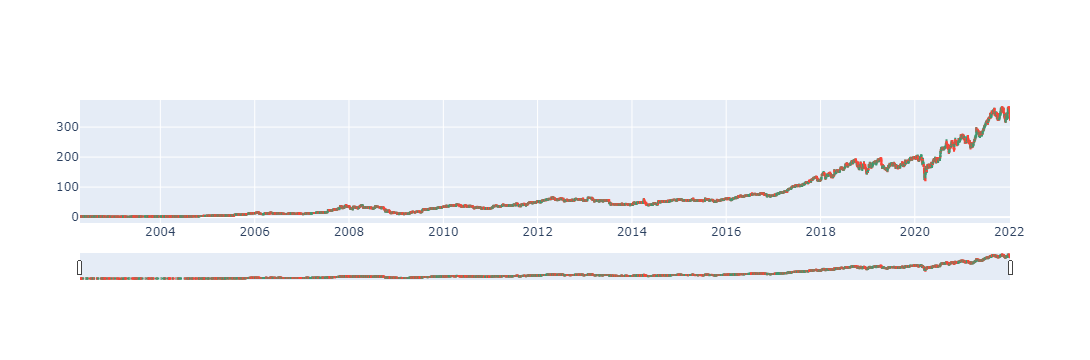

In [29]:
#This graph will give you the candlestick pattern.  When you hover over the candles, you will see the pattern at the time at which you hover the cursor
import plotly.graph_objects as go
fig = go.Figure(data=[go.Candlestick(x=df_stock.index,
                open=df_stock['Open'],
                high=df_stock['High'],
                low=df_stock['Low'],
                close=df_stock['Close'])])
fig.update_traces(text=df_stock['pattern'], selector=dict(type='candlestick'))
fig.show()

In [30]:
#Dictionary of patterns with definitions
pattern_dict = {
    'Bullish swing': 'upswing pattern',
    'Bearish swing': 'downward pattern',
    'Bullish pinbar': 'upswing hammer',
    'Bearish pinbar': 'downswing hammer',
    'Inside bar': 'trend change',
    'Outside bar': 'trend change',
    'Bullish engulfing': 'upswing from downtrend',
    'Bearish engulfing': 'downswing from uptrend',
    'No pattern': 'No pattern detected'
    }
#This will give the most current pattern from the dataframe
today = df_stock['pattern'][-1]
for i in today:
    print(f'Todays pattern is {i}, {pattern_dict[i]}')

Todays pattern is No pattern, No pattern detected


In [31]:
def last_pattern():
#Dictionary of patterns with definitions
    pattern_dict = {
        'Bullish swing': 'upswing pattern',
        'Bearish swing': 'downward pattern',
        'Bullish pinbar': 'upswing hammer',
        'Bearish pinbar': 'downswing hammer',
        'Inside bar': 'trend change',
        'Outside bar': 'trend change',
        'Bullish engulfing': 'upswing from downtrend',
        'Bearish engulfing': 'downswing from uptrend',
        'No pattern': 'No pattern detected'
        }
    #This will give the most current pattern from the dataframe
    today = df_stock['pattern'][-1]
    for i in today:
        print(f'Todays pattern is {i}, {pattern_dict[i]}')

In [32]:
last_pattern()

Todays pattern is No pattern, No pattern detected


In [33]:
#checks the momentum based on the EMA's stacking
#If smaller EMA's stack above the larger, the momentum is positive, vice versa, negative
def momentum_checker(index):
    if (df_stock['m_avg_08'][index] > df_stock['m_avg_21'][index] > df_stock['m_avg_34'][index] > df_stock['m_avg_55'][index] > df_stock['m_avg_89'][index]):
        print('Positive momentum')
    elif (df_stock['m_avg_08'][index] < df_stock['m_avg_21'][index] < df_stock['m_avg_34'][index] < df_stock['m_avg_55'][index] < df_stock['m_avg_89'][index]):
        print('Negative momentum')
    else:
        print('neutral')

In [34]:
#This code throws up a flag to show if the trend of the stock is up, down, or sideways
#It uses the average directional index to determine the strength of the trend
#If ADX > 20 and the plus_di is above the minus_di the trend is positive
#If ADX > 20 and the plus_di is below the minus_di the trend is negative
#If ADX < 20 the trend is sideways

df_stock['ADX_trend'] = 20

def ADX_trend_flag(index):
    if (df_stock['adx'][index] > df_stock['ADX_trend'][index]) and (df_stock['plus_di'][index] > df_stock['minus_di'][index]):
        print('positive trend')
    elif (df_stock['adx'][index] > df_stock['ADX_trend'][index]) and (df_stock['plus_di'][index] < df_stock['minus_di'][index]):
        print('negative trend')
    elif (df_stock['adx'][index] < df_stock['ADX_trend'][index]):
        print('neutral or sideways trend')

In [35]:
#This code gives an early warning if the 8 EMA crosses the 21 to the downside and amplifies the warning if it crosses the 34
#This is especially critical if it is happening to one of the market indices
def warning(index):
    if (df_stock['m_avg_08'][index] < df_stock['m_avg_21'][index]):
        print('Warning, stock maybe heading down, consider puts on pullback to the 8 EMA as long as we see red on the squeeze histograms, and hold off on long positions.  Watch ADX for negative trend. If this happens with any of the market indices such as SPY, QQQ, or DJI, hold of on long positions and consider puts.  Watch the chart for the 8 crossing the 34.')
    if (df_stock['m_avg_08'][index] < df_stock['m_avg_34'][index]):
        print('8 EMA has crossed 34 to the downside.  As long as there is tension in the news, you can short or buy puts on any price moves back to the 8 or the 21 ema')
    elif (df_stock['m_avg_08'][index] > df_stock['m_avg_21'][index]):
        print('Continue as normal and watch for bearish candle patterns, especially when market is overbought and at the top bollinger')

In [36]:
#Warning flag to show if the squeeze is on and what market cycle the stock or index is in
def squeeze_flag(index):
    if (df_stock['squeeze_on'][index] == 1.0):
        print('squeeze is on')
    else:
        print('squeeze is off')
    
def squeeze_momentum(index):    
    if (df_stock['colors'][index] == 'cyan'):
        print('stock is in a mark up mode')
    elif (df_stock['colors'][index] == 'blue'):
        print('stock is in a distribution mode')
    elif (df_stock['colors'][index] == 'yellow'):
        print('stock is in an accumulation mode')
    elif (df_stock['colors'][index] == 'red'):
        print('stock is in a mark down mode')

In [37]:
def BB_flag(index):
    if df_stock['bol_percent_b'][index] >= df_stock['percent_b_high'][index]:
        print('stock is very close to the upper bollinger, watch the candles for bearishness and possible news and either take profits or start hedging.  Also watch for squeeze')
    elif  df_stock['bol_percent_b'][index] <= df_stock['percent_b_low'][index]:
        print('stock is very close to the lower bollinger or even below it, watch the candles for bullishness and possible news.  Cover shorts if any or start looking to buy if the market is conducive.  Watch for squeeze as well')
    else:
        print('stock is between the bollingers at the moment, it is neutral')

In [38]:
def stoch_flag(index):
    if (df_stock["slow_K"][index] < df_stock['Oversold'][index]):
        print('stochastics indicate stock is oversold')
    elif (df_stock["slow_K"][index] > df_stock['Overbought'][index]):
        print('stochastics indicate stock is overbought')
    else:
        print('stock is neutral with the stochastics')

In [39]:
def rsi_flag(index):
    if (df_stock['rsi_14'][index] < df_stock['Oversold'][index]):
        print('rsi indicates stock is oversold')
    elif (df_stock["rsi_14"][index] > df_stock['Overbought'][index]):
        print('rsi indicates stock is overbought')
    else:
        print('stock is neutral with the rsi')

In [40]:
squeeze_flag(-1)

squeeze is off


In [41]:
squeeze_momentum(-1)

stock is in a distribution mode


In [42]:
momentum_checker(-1)

neutral


In [43]:
ADX_trend_flag(-1)

neutral or sideways trend


In [44]:
warning(-1)

Warning, stock maybe heading down, consider puts on pullback to the 8 EMA as long as we see red on the squeeze histograms, and hold off on long positions.  Watch ADX for negative trend. If this happens with any of the market indices such as SPY, QQQ, or DJI, hold of on long positions and consider puts.  Watch the chart for the 8 crossing the 34.
8 EMA has crossed 34 to the downside.  As long as there is tension in the news, you can short or buy puts on any price moves back to the 8 or the 21 ema


In [45]:
BB_flag(-1)

stock is between the bollingers at the moment, it is neutral


In [46]:
stoch_flag(-1)

stochastics indicate stock is oversold


In [47]:
rsi_flag(-1)

stock is neutral with the rsi


In [48]:
import contextlib
file_path_d = f'{value}flagsdaily.txt'
with open(file_path_d, "w") as o:
    with contextlib.redirect_stdout(o):
        last_pattern()
        squeeze_flag(-1)
        squeeze_momentum(-1)
        momentum_checker(-1)
        ADX_trend_flag(-1)
        warning(-1)
        BB_flag(-1)
        stoch_flag(-1)
        rsi_flag(-1)

In [49]:
# Python code to illustrate Sending mail with attachments 
# from your Gmail account  
  
# libraries to be imported 
import smtplib 
from email.mime.multipart import MIMEMultipart 
from email.mime.text import MIMEText 
from email.mime.base import MIMEBase 
from email import encoders 
   
fromaddr = "akkrishn1@gmail.com"
toaddr = "fastandtheferocious@gmail.com"
   
# instance of MIMEMultipart 
msg = MIMEMultipart() 
  
# storing the senders email address   
msg['From'] = fromaddr 
  
# storing the receivers email address  
msg['To'] = toaddr 
  
# storing the subject  
msg['Subject'] = f"{value} flags"
  
# string to store the body of the mail 
body = f"Here are the flags for {value} on the daily chart"
  
# attach the body with the msg instance 
msg.attach(MIMEText(body, 'plain')) 
  
# open the file to be sent  
filename = f"{value}flagsdaily.txt"
attachment = open(f"C:/Users/akkrishn/SqueezeMeBabyOneMoreTime/{value}flagsdaily.txt", "rb") 
  
# instance of MIMEBase and named as p 
p = MIMEBase('application', 'octet-stream') 
  
# To change the payload into encoded form 
p.set_payload((attachment).read()) 
  
# encode into base64 
encoders.encode_base64(p) 
   
p.add_header('Content-Disposition', "attachment; filename= %s" % filename) 
  
# attach the instance 'p' to instance 'msg' 
msg.attach(p) 
  
# creates SMTP session 
s = smtplib.SMTP('smtp.gmail.com', 587) 
  
# start TLS for security 
s.starttls() 
  
# Authentication 
s.login(fromaddr, "Kr15hn40709") 
  
# Converts the Multipart msg into a string 
text = msg.as_string() 
  
# sending the mail 
s.sendmail(fromaddr, toaddr, text) 
  
# terminating the session 
s.quit() 

(221, b'2.0.0 closing connection e5sm1315087pjr.53 - gsmtp')

In [50]:
# To get the entry and exit signals for the algo trading using squeeze and momentum
# The threshold is to set the histogram of the squeeze as close to the zero line as possible
# We want the squeeze to be on and the histogram to be close to zero and the color of the histogram to be yellow or cyan indicating accumulation
# or markup
t_percent = float(input("enter threshold percentage"))
df_stock['value_threshold'] = abs(df_stock['value'].min()* t_percent)
df_stock['squeeze_threshold'] = 1.0
df_stock["squeeze_entry"] = np.logical_and(np.greater(df_stock["value"], df_stock['value_threshold']), 
                                           np.equal(df_stock['squeeze_on'], df_stock['squeeze_threshold']))
df_stock['squeeze_entry'] = df_stock['squeeze_entry'].astype(float)
df_stock['Entry/Exit'] = df_stock['squeeze_entry'].diff()
df_stock_clean = df_stock.dropna()


enter threshold percentage .05


In [51]:
#This is the algo strategy.  The entry is when the squeeze is on and the histogram is near 0 and either yellow or cyan as stated before
#Exit strategy is when the stock moves up any percent you want to input
#The form of input is 1.something
#this means for example 1.5 means 50%

percent = float(input("Enter percent return"))
def implement_bb_strategy(data, squeeze_on, squeeze_value, upper_kc, threshold, color, percent):
    buy_price = []
    sell_price = []
    squeeze_signal = []
    signal = 0.0
    buy_close = 0
    buy = False

    
    for close, squeeze, value, kc, thresh, color  in zip(data, squeeze_on, squeeze_value, upper_kc, threshold, color):
        if squeeze == 1.0 and value < thresh and (color == 'yellow' or color == 'cyan'):
            if signal != 1:
                buy_price.append(close)
                buy = True
                sell_price.append(np.nan)
                buy_close = close
                signal = 1.0
                squeeze_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                squeeze_signal.append(0)
        elif buy and close >= (buy_close*percent):
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(close)
                signal = -1
                buy = False
                squeeze_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                squeeze_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            squeeze_signal.append(0)
            
    return buy_price, sell_price, squeeze_signal

Enter percent return 1.10


In [52]:
# calling the algo function and returning the buy price, sell price, and the squeeze signal
buy_price, sell_price, squeeze_signal = implement_bb_strategy(df_stock["Close"], df_stock['squeeze_on'], df_stock['value'], 
                                                              df_stock['upper_KC'], df_stock['value_threshold'], df_stock['colors'], percent)

In [53]:
#setting dataframes to the results of the algo function
df_stock['buy_price'] =  buy_price
df_stock['sell_price'] = sell_price
df_stock['squeeze_signal'] = squeeze_signal

In [55]:
# This is give the entry and exit signals in the form of a green triangle and red triangle respectively
# Visualize exit position relative to close price
exit = df_stock[df_stock['squeeze_signal'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = df_stock[df_stock['squeeze_signal'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = df_stock[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

entry_exit_plot = security_close * entry * exit
entry_exit_plot

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

In [56]:
def algo_plot_daily():
    # This is give the entry and exit signals in the form of a green triangle and red triangle respectively
    # Visualize exit position relative to close price
    exit = df_stock[df_stock['squeeze_signal'] == -1.0]['Close'].hvplot.scatter(
        color='red',
        marker='v',
        size=200,
        legend=False,
        ylabel='Price in $',
        width=1000,
        height=400
    )

    # Visualize entry position relative to close price
    entry = df_stock[df_stock['squeeze_signal'] == 1.0]['Close'].hvplot.scatter(
        color='green',
        marker='^',
        size=200,
        legend=False,
        ylabel='Price in $',
        width=1000,
        height=400
    )

    # Visualize close price for the investment
    security_close = df_stock[['Close']].hvplot(
        line_color='lightgray',
        ylabel='Price in $',
        width=1000,
        height=400
    )

    entry_exit_plot = security_close * entry * exit
    return entry_exit_plot

In [57]:
algo_plot_daily()

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

In [58]:
# This code tells us to enter into a position when the squeeze signal is triggered according to the algo function given above
position = []
for i in range(len(squeeze_signal)):
    if df_stock['squeeze_signal'][i] < 1:
        position.append(0)
    else:
        position.append(1)

        
for i in range(len(df_stock['Close'])):
    if df_stock['squeeze_signal'][i] == 1:
        position[i] = 1
    elif df_stock['squeeze_signal'][i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
#upper_bb = tsla['upper_bb']
#lower_bb = tsla['lower_bb']
close_price = df_stock['Close']
squeeze_signal = pd.DataFrame(squeeze_signal).rename(columns = {0:'squeeze_signal'}).set_index(df_stock.index)
position = pd.DataFrame(position).rename(columns = {0:'squeeze_position'}).set_index(df_stock.index)

frames = [close_price, squeeze_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)
strategy = strategy.reset_index()

strategy.tail()

Date       Close  squeeze_signal  squeeze_position
4962 2022-01-03  360.000000             0.0                 1
4963 2022-01-04  354.630005             0.0                 1
4964 2022-01-05  341.950012             0.0                 1
4965 2022-01-06  334.179993             0.0                 1
4966 2022-01-07  324.290009             0.0                 1

In [59]:
#This code gives us the results of the Algo trade compounding the % return and starting with 100000 as the initial investment and telling 

stock_ret = pd.DataFrame(np.diff(df_stock['Close'])).rename(columns = {0:'returns'})
squeeze_strategy_ret = []
return_sum = 0

for i in range(len(stock_ret)):
    try:
        returns = stock_ret['returns'][i]*strategy['squeeze_position'][i]
        squeeze_strategy_ret.append(returns)
    except:
        pass
    
squeeze_strategy_ret_df = pd.DataFrame(squeeze_strategy_ret).rename(columns = {0:'squeeze_returns'})

investment_value = 100000
number_of_stocks = math.floor(investment_value/df_stock['Close'][-1])
squeeze_investment_ret = []

for i in range(len(squeeze_strategy_ret_df['squeeze_returns'])):
    #df_stock_wk['cumluative_return'] = np.exp(np.log1p(df_stock_wk['pct_change']).cumsum())
    returns = (number_of_stocks*squeeze_strategy_ret_df['squeeze_returns'][i])
    squeeze_investment_ret.append(returns)
    return_sum += returns
    new_investment_value = return_sum + investment_value
    number_of_stocks = math.floor(new_investment_value/df_stock['Close'][i-1])
    
squeeze_investment_ret_df = pd.DataFrame(squeeze_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(squeeze_investment_ret_df['investment_returns']), 2)
profit_percentage = math.floor((total_investment_ret/investment_value)*100)
print(f'Profit gained from the Squeeze strategy by investing $100k in {value} is {total_investment_ret}')
print(f'Profit percentage of the Squeeze strategy : {profit_percentage}%')
print(return_sum)


Profit gained from the Squeeze strategy by investing $100k in isrg is 4996982.88
Profit percentage of the Squeeze strategy : 4996%
4996982.878857017


In [54]:
def daily_algo_return():
    stock_ret = pd.DataFrame(np.diff(df_stock['Close'])).rename(columns = {0:'returns'})
    squeeze_strategy_ret = []
    return_sum = 0

    for i in range(len(stock_ret)):
        try:
            returns = stock_ret['returns'][i]*strategy['squeeze_position'][i]
            squeeze_strategy_ret.append(returns)
        except:
            pass

    squeeze_strategy_ret_df = pd.DataFrame(squeeze_strategy_ret).rename(columns = {0:'squeeze_returns'})

    investment_value = 100000
    number_of_stocks = math.floor(investment_value/df_stock['Close'][-1])
    squeeze_investment_ret = []

    for i in range(len(squeeze_strategy_ret_df['squeeze_returns'])):
        #df_stock_wk['cumluative_return'] = np.exp(np.log1p(df_stock_wk['pct_change']).cumsum())
        returns = (number_of_stocks*squeeze_strategy_ret_df['squeeze_returns'][i])
        squeeze_investment_ret.append(returns)
        return_sum += returns
        new_investment_value = return_sum + investment_value
        number_of_stocks = math.floor(new_investment_value/df_stock['Close'][i-1])

    squeeze_investment_ret_df = pd.DataFrame(squeeze_investment_ret).rename(columns = {0:'investment_returns'})
    total_investment_ret = round(sum(squeeze_investment_ret_df['investment_returns']), 2)
    profit_percentage = math.floor((total_investment_ret/investment_value)*100)
    return f'Profit gained from the Squeeze strategy by investing $100k in {value} is {total_investment_ret} and the profit percent is {profit_percentage}%'
    #print(f'Profit percentage of the Squeeze strategy : {profit_percentage}%')
    #print(return_sum)

In [55]:
daily_algo_return()

'Profit gained from the Squeeze strategy by investing $100k in nvda is 1179632.21 and the profit percent is 1179%'

#Hourly Analysis

In [149]:
momentum_checker_hr(-1)

'neutral'

In [150]:
ADX_trend_flag_hr(-1)

'positive trend'

In [151]:
warning_hr(-1)

'Warning, stock maybe heading down, consider puts on pullback to the 8 EMA, and hold off on long positions.  Watch ADX for negative trend. If this happens with any of the market indices such as SPY, QQQ, or DJI, hold of on long positions.  Watch the chart for the 8 crossing the 34. Trends on the hourly may be short-lived'

In [152]:
squeeze_flag_hr(-1)

'squeeze is off'

In [153]:
squeeze_momentum_hr(-1)

'stock is in a mark down mode'

In [154]:
upper_BB_flag_hr(-1)

'There is room to run for the moment'

In [155]:
# To get the entry and exit signals for the algo trading using squeeze and momentum
# The threshold is to set the histogram of the squeeze as close to the zero line as possible
# We want the squeeze to be on and the histogram to be close to zero and the color of the histogram to be yellow or cyan indicating accumulation
# or markup
t_percent_hr = float(input("enter threshold percentage"))
df_stock_hr['value_threshold'] = abs(df_stock_hr['value'].min()* t_percent_hr)
df_stock_hr['squeeze_threshold'] = 1.0
df_stock_hr["squeeze_entry"] = np.logical_and(np.greater(df_stock_hr["value"], df_stock_hr['value_threshold']), 
                                           np.equal(df_stock_hr['squeeze_on'], df_stock_hr['squeeze_threshold']))
df_stock_hr['squeeze_entry'] = df_stock_hr['squeeze_entry'].astype(float)
df_stock_hr['Entry/Exit'] = df_stock_hr['squeeze_entry'].diff()
df_stock_hr_clean = df_stock_hr.dropna()

enter threshold percentage .05


In [156]:
#This is the algo strategy.  The entry is when the squeeze is on and the histogram is near 0 and either yellow or cyan as stated before
#Exit strategy is when the stock moves up any percent you want to input
#The form of input is 1.something
#this means for example 1.5 means 50%

percent = float(input("Enter percent return"))
def implement_bb_strategy(data, squeeze_on, squeeze_value, upper_kc, threshold, color, percent):
    buy_price = []
    sell_price = []
    squeeze_signal = []
    signal = 0.0
    buy_close = 0
    buy = False

    
    for close, squeeze, value, kc, thresh, color  in zip(data, squeeze_on, squeeze_value, upper_kc, threshold, color):
        if squeeze == 1.0 and value < thresh and (color == 'yellow' or color == 'cyan'):
            if signal != 1:
                buy_price.append(close)
                buy = True
                sell_price.append(np.nan)
                buy_close = close
                signal = 1.0
                squeeze_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                squeeze_signal.append(0)
        elif buy and close >= (buy_close*percent):
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(close)
                signal = -1
                buy = False
                squeeze_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                squeeze_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            squeeze_signal.append(0)
            
    return buy_price, sell_price, squeeze_signal

Enter percent return 1.10


In [157]:
# calling the algo function and returning the buy price, sell price, and the squeeze signal
buy_price_hr, sell_price_hr, squeeze_signal_hr = implement_bb_strategy(df_stock_hr["Close"], df_stock_hr['squeeze_on'], df_stock_hr['value'], 
                                                              df_stock_hr['upper_KC'], df_stock_hr['value_threshold'], df_stock_hr['colors'], percent)

In [158]:
#setting dataframes to the results of the algo function
df_stock_hr['buy_price'] =  buy_price_hr
df_stock_hr['sell_price'] = sell_price_hr
df_stock_hr['squeeze_signal'] = squeeze_signal_hr

In [159]:
# This is give the entry and exit signals in the form of a green triangle and red triangle respectively
# Visualize exit position relative to close price
exit = df_stock_hr[df_stock_hr['squeeze_signal'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = df_stock_hr[df_stock_hr['squeeze_signal'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = df_stock_hr[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

entry_exit_plot = security_close * entry * exit
entry_exit_plot

:Overlay
   .Curve.I          :Curve   [index]   (Close)
   .Scatter.Close.I  :Scatter   [index]   (Close)
   .Scatter.Close.II :Scatter   [index]   (Close)

In [160]:
# This code tells us to enter into a position when the squeeze signal is triggered according to the algo function given above
position = []
for i in range(len(squeeze_signal_hr)):
    if df_stock_hr['squeeze_signal'][i] < 1:
        position.append(0)
    else:
        position.append(1)

        
for i in range(len(df_stock_hr['Close'])):
    if df_stock_hr['squeeze_signal'][i] == 1:
        position[i] = 1
    elif df_stock_hr['squeeze_signal'][i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
#upper_bb = tsla['upper_bb']
#lower_bb = tsla['lower_bb']
close_price = df_stock_hr['Close']
squeeze_signal_hr = pd.DataFrame(squeeze_signal_hr).rename(columns = {0:'squeeze_signal'}).set_index(df_stock_hr.index)
position = pd.DataFrame(position).rename(columns = {0:'squeeze_position'}).set_index(df_stock_hr.index)

frames = [close_price, squeeze_signal_hr, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)
strategy = strategy.reset_index()

strategy.tail()

index      Close  squeeze_signal  squeeze_position
3449 2021-12-06 11:30:00-05:00  28.520000             0.0                 1
3450 2021-12-06 12:30:00-05:00  27.190001             0.0                 1
3451 2021-12-06 13:30:00-05:00  27.080000             0.0                 1
3452 2021-12-06 14:30:00-05:00  27.629999             0.0                 1
3453 2021-12-06 15:30:00-05:00  27.500000             0.0                 1

In [161]:
#This code gives us the results of the Algo trade compounding the % return and starting with 100000 as the initial investment and telling 

stock_ret = pd.DataFrame(np.diff(df_stock_hr['Close'])).rename(columns = {0:'returns'})
squeeze_strategy_ret = []
return_sum = 0

for i in range(len(stock_ret)):
    try:
        returns = stock_ret['returns'][i]*strategy['squeeze_position'][i]
        squeeze_strategy_ret.append(returns)
    except:
        pass
    
squeeze_strategy_ret_df = pd.DataFrame(squeeze_strategy_ret).rename(columns = {0:'squeeze_returns'})

investment_value = 100000
number_of_stocks = math.floor(investment_value/df_stock_hr['Close'][-1])
squeeze_investment_ret = []

for i in range(len(squeeze_strategy_ret_df['squeeze_returns'])):
    #df_stock_wk['cumluative_return'] = np.exp(np.log1p(df_stock_wk['pct_change']).cumsum())
    returns = (number_of_stocks*squeeze_strategy_ret_df['squeeze_returns'][i])
    squeeze_investment_ret.append(returns)
    return_sum += returns
    new_investment_value = return_sum + investment_value
    number_of_stocks = math.floor(new_investment_value/df_stock_hr['Close'][i-1])
    
squeeze_investment_ret_df = pd.DataFrame(squeeze_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(squeeze_investment_ret_df['investment_returns']), 2)
profit_percentage = math.floor((total_investment_ret/investment_value)*100)
print(f'Profit gained from the Squeeze strategy by investing $100k in {value} is {total_investment_ret}')
print(f'Profit percentage of the Squeeze strategy : {profit_percentage}%')
print(return_sum)

Profit gained from the Squeeze strategy by investing $100k in ^vix is 194.56
Profit percentage of the Squeeze strategy : 0%
194.56457328796387


#Weekly Analysis

In [162]:
#This block of code pulls the weekly candlestick periods from Yahoo Finance and makes it into a dataframe
stock_df_wk = stock.history(period="20y", interval='1wk')
stock_df.index.duplicated().sum()
df_stock_wk = stock_df_wk.loc[~stock_df_wk.index.duplicated(keep='first')]
df_stock_wk.dropna(inplace=True)
df_stock_wk.tail()

Open   High        Low      Close  Volume  Dividends  \
Date                                                                    
2021-11-08  17.230000  19.90  16.150000  16.290001       0          0   
2021-11-15  17.030001  19.01  16.030001  17.910000       0          0   
2021-11-22  18.200001  28.99  17.350000  28.620001       0          0   
2021-11-29  25.309999  35.32  21.709999  30.670000       0          0   
2021-12-06  28.990000  30.82  26.750000  27.180000       0          0   

            Stock Splits  
Date                      
2021-11-08             0  
2021-11-15             0  
2021-11-22             0  
2021-11-29             0  
2021-12-06             0

In [163]:
# calculate Bollinger Bands on weekly data
# moving average
#m_avg = df_stock['Close'].rolling(window=length).mean()
m_avg_wk = df_stock_wk['Close'].ewm(span=length).mean()
df_stock_wk['Moving average weekly'] = m_avg_wk
# standard deviation
m_std_wk = df_stock_wk['Close'].rolling(window=length).std(ddof=0)
# upper Bollinger Bands
df_stock_wk['upper_BB'] = m_avg_wk + mult * m_std_wk
# lower Bollinger Bands 
df_stock_wk['lower_BB'] = m_avg_wk - mult * m_std_wk

In [164]:
#Stacked Moving averages weekly, again, Fibonacci style moving averages
m_avg_08_wk = df_stock_wk['Close'].ewm(span=8).mean()
m_avg_21_wk = df_stock_wk['Close'].ewm(span=21).mean()
m_avg_34_wk = df_stock_wk['Close'].ewm(span=34).mean()
m_avg_55_wk = df_stock_wk['Close'].ewm(span=55).mean()
m_avg_89_wk = df_stock_wk['Close'].ewm(span=89).mean()

df_stock_wk['m_avg_08'] = m_avg_08_wk
df_stock_wk['m_avg_21'] = m_avg_21_wk
df_stock_wk['m_avg_34'] = m_avg_34_wk
df_stock_wk['m_avg_55'] = m_avg_55_wk
df_stock_wk['m_avg_89'] = m_avg_89_wk

In [165]:
# calculate Keltner Channel weekly
# first we need to calculate True Range
df_stock_wk['tr0'] = abs(df_stock_wk["High"] - df_stock_wk["Low"])
df_stock_wk['tr1'] = abs(df_stock_wk["High"] - df_stock_wk["Close"].shift())
df_stock_wk['tr2'] = abs(df_stock_wk["Low"] - df_stock_wk["Close"].shift())
df_stock_wk['tr'] = df_stock_wk[['tr0', 'tr1', 'tr2']].max(axis=1)
# moving average of the TR or average true range
range_ma_wk = df_stock_wk['tr'].ewm(span=length_KC).mean()
# upper Keltner Channel
df_stock_wk['upper_KC'] = m_avg_wk + range_ma_wk * mult_KC
# lower Keltner Channel
df_stock_wk['lower_KC'] = m_avg_wk - range_ma_wk * mult_KC

In [166]:
#ADX Calculations weekly

plus_dm_wk = df_stock_wk["High"].diff()
minus_dm_wk = df_stock_wk["Low"].diff()
plus_dm_wk[plus_dm_wk < 0] = 0
minus_dm_wk[minus_dm_wk > 0] = 0

df_stock_wk['atr'] = df_stock_wk['tr'].ewm(span=14).mean()
df_stock_wk['plus_di'] = 100 * (plus_dm_wk.ewm(alpha = 1/14).mean() / df_stock_wk['atr'])
df_stock_wk['minus_di'] = abs(100 * (minus_dm_wk.ewm(alpha = 1/14).mean() / df_stock_wk['atr']))
dx_wk = (abs(df_stock_wk['plus_di'] - df_stock_wk['minus_di']) / abs(df_stock_wk['plus_di'] + df_stock_wk['minus_di'])) * 100
adx_wk = ((dx_wk.shift(1) * (14 - 1)) + dx_wk) / 14
df_stock_wk['adx'] = adx_wk.ewm(alpha = 1/14).mean()

In [167]:
# check for 'squeeze' weekly
df_stock_wk['squeeze_on'] = (df_stock_wk['lower_BB'] > df_stock_wk['lower_KC']) & (df_stock_wk['upper_BB'] < df_stock_wk['upper_KC'])
df_stock_wk['squeeze_off'] = (df_stock_wk['lower_BB'] < df_stock_wk['lower_KC']) & (df_stock_wk['upper_BB'] > df_stock_wk['upper_KC'])

In [168]:
# Momentum weekly for the squeeze indicator
highest_wk = df_stock_wk['High'].rolling(window = length_KC).max()
lowest_wk = df_stock_wk['Low'].rolling(window = length_KC).min()
m1_wk = (highest_wk + lowest_wk) / 2
df_stock_wk['value'] = (df_stock_wk['Close'] - (m1_wk + m_avg_wk)/2)
fit_y_wk = np.array(range(0,length_KC))
df_stock_wk['value'] = df_stock_wk['value'].rolling(window = length_KC).apply(lambda x : np.polyfit(fit_y_wk, x, 1)[0] * (length_KC-1) +
   np.polyfit(fit_y_wk, x, 1)[1], raw=True)

df_stock_wk[['squeeze_on', 'squeeze_off']] = (df_stock_wk[['squeeze_on', 'squeeze_off']] == True).astype(int)

df_stock_wk["pct_change"] = df_stock_wk['Close'].pct_change()

"""
conditions = [
    (df_stock['pct_change'] > 0) | (df_stock['squeeze_on'] == 1),
    (df_stock['pct_change'] < 0) | (df_stock['squeeze_on'] == 0)
]
"""
conditions_wk =  [
    (df_stock_wk['pct_change'] > 0),
    (df_stock_wk['pct_change'] < 0)
]

label = [1, 0]
df_stock_wk['profitable?'] = np.select(conditions_wk, label) 
df_stock_wk.dropna(inplace=True)
df_stock_wk

Open       High        Low      Close  Volume  Dividends  \
Date                                                                        
2002-09-09  39.099998  39.630001  33.720001  35.820000       0          0   
2002-09-16  37.340000  40.700001  35.790001  38.980000       0          0   
2002-09-23  40.779999  41.340000  33.959999  36.970001       0          0   
2002-09-30  41.070000  41.860001  33.770000  39.459999       0          0   
2002-10-07  41.650002  43.439999  35.200001  35.700001       0          0   
...               ...        ...        ...        ...     ...        ...   
2021-11-08  17.230000  19.900000  16.150000  16.290001       0          0   
2021-11-15  17.030001  19.010000  16.030001  17.910000       0          0   
2021-11-22  18.200001  28.990000  17.350000  28.620001       0          0   
2021-11-29  25.309999  35.320000  21.709999  30.670000       0          0   
2021-12-06  28.990000  30.820000  26.750000  27.180000       0          0   

            Stock Splits  Moving average weekly   upper_BB   lower_BB  \
Date                                                                    
2002-09-09             0              30.163619  43.848656  16.478582   
2002-09-16             0              31.016012  44.807116  17.224907   
2002-09-23             0              31.590830  45.309743  17.871917   
2002-09-30             0              32.349556  45.298527  19.400585   
2002-10-07             0              32.672217  44.365962  20.978471   
...                  ...                    ...        ...        ...   
2021-11-08             0              17.579375  21.208764  13.949986   
2021-11-15             0              17.610863  21.081370  14.140356   
2021-11-22             0              18.659352  24.542428  12.776277   
2021-11-29             0              19.803224  27.823341  11.783106   
2021-12-06             0              20.505774  29.275669  11.735879   

             m_avg_08   m_avg_21   m_avg_34   m_avg_55   m_avg_89        tr0  \
Date                                                                           
2002-09-09  33.528407  29.953533  28.095293  26.793645  25.980791   5.910000   
2002-09-16  34.739903  30.789384  28.774666  27.349555  26.453671   4.910000   
2002-09-23  35.235491  31.360743  29.283498  27.784111  26.830890   7.380001   
2002-09-30  36.174285  32.108321  29.912228  28.306571  27.277794   8.090000   
2002-10-07  36.068887  32.439379  30.268159  28.634443  27.571957   8.239998   
...               ...        ...        ...        ...        ...        ...   
2021-11-08  16.967896  17.628574  18.394833  19.556710  20.395486   3.750000   
2021-11-15  17.177252  17.654158  18.367129  19.497899  20.340253   2.980000   
2021-11-22  19.720085  18.651053  18.953007  19.823688  20.524247  11.639999   
2021-11-29  22.153400  19.743685  19.622549  20.211056  20.749708  13.610001   
2021-12-06  23.270422  20.419713  20.054404  20.459947  20.892604   4.070000   

                  tr1       tr2         tr   upper_KC   lower_KC       atr  \
Date                                                                         
2002-09-09   3.299999  2.610001   5.910000  43.190389  17.136850  6.949634   
2002-09-16   4.880001  0.029999   4.910000  43.745835  18.286189  6.677014   
2002-09-23   2.360001  5.020000   7.380001  44.508330  18.673330  6.770945   
2002-09-30   4.889999  3.200001   8.090000  45.568191  19.130920  6.947144   
2002-10-07   3.980000  4.259998   8.239998  46.191464  19.152970  7.119800   
...               ...       ...        ...        ...        ...       ...   
2021-11-08   3.420000  0.330000   3.750000  27.228866   7.929884  4.606871   
2021-11-15   2.719999  0.260000   2.980000  26.924946   8.296780  4.389955   
2021-11-22  11.080000  0.559999  11.639999  29.243064   8.075641  5.356628   
2021-11-29   6.699999  6.910002  13.610001  31.899325   7.707122  6.457077   
2021-12-06   0.150000  3.920000   4.070000  32.242230   8.769318  6.138800   

         

In [169]:
# entry point for long position on the weekly chart:
# 1. black cross becomes gray (the squeeze is released)
long_cond1_wk = (df_stock_wk['squeeze_off'][-2] == 0) | (df_stock_wk['squeeze_off'][-1] == 1) 
# 2. bar value is positive => the bar is light green
long_cond2_wk = df_stock_wk['value'][-1] > 0

enter_long_wk = long_cond1_wk and long_cond2_wk
# entry point for short position on the weekly chart:
# 1. black cross becomes gray (the squeeze is released)
short_cond1_wk = (df_stock_wk['squeeze_off'][-2] == 0) | (df_stock_wk['squeeze_off'][-1] == 1) 
# 2. bar value is negative => the bar is light red 
short_cond2_wk = df_stock_wk['value'][-1] < 0
enter_short_wk = short_cond1_wk and short_cond2_wk

In [170]:
ohcl_wk = df_stock_wk[['Open', 'High', 'Close', 'Low']]
ohcl_wk.head()

Open       High      Close        Low
Date                                                  
2002-09-09  39.099998  39.630001  35.820000  33.720001
2002-09-16  37.340000  40.700001  38.980000  35.790001
2002-09-23  40.779999  41.340000  36.970001  33.959999
2002-09-30  41.070000  41.860001  39.459999  33.770000
2002-10-07  41.650002  43.439999  35.700001  35.200001

In [171]:
# add colors for the 'value bar'
colors = []
for ind, val in enumerate(df_stock_wk['value']):
  if val >= 0:
    color = 'blue'
    if val > df_stock_wk['value'][ind-1]:
      color = 'cyan'
  else:
    color = 'yellow'
    if val < df_stock_wk['value'][ind-1]:
      color='red'
  colors.append(color)

df_stock_wk['colors'] = colors
df_stock_wk['ADX_trend']=20

In [172]:
# add 2 subplots: 1. bars, 2. crosses
apds = [mpf.make_addplot(df_stock_wk['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
        mpf.make_addplot([0] * len(df_stock_wk), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock_wk['squeeze_off']], secondary_y=False),
        mpf.make_addplot(df_stock_wk[['upper_BB']], color = 'red'),
        mpf.make_addplot(df_stock_wk[['lower_BB']], color = 'red'),
        mpf.make_addplot(df_stock_wk[['upper_KC']], color = 'blue'),
        mpf.make_addplot(df_stock_wk[['lower_KC']], color = 'blue'),
        mpf.make_addplot(df_stock_wk['Moving average weekly'], color = 'black'),
        mpf.make_addplot(df_stock_wk['m_avg_08'], color='green'),
        mpf.make_addplot(df_stock_wk['m_avg_34'], color='orange'),
        mpf.make_addplot(df_stock_wk[['adx']], panel=4, color = 'purple', secondary_y=False),
        mpf.make_addplot(df_stock_wk[['plus_di']], panel=4, color = 'green', secondary_y=False),
        mpf.make_addplot(df_stock_wk[['minus_di']], panel=4, color = 'orange', secondary_y=False),
        mpf.make_addplot(df_stock_wk[['ADX_trend']], panel=4, color = 'red', secondary_y=False),
        mpf.make_addplot(df_stock_wk['m_avg_08'], panel=3, color='red', secondary_y=False),
        mpf.make_addplot(df_stock_wk['m_avg_21'], panel=3, color='orange', secondary_y=False),
        mpf.make_addplot(df_stock_wk['m_avg_34'], panel=3, color='yellow', secondary_y=False),
        mpf.make_addplot(df_stock_wk['m_avg_55'], panel=3, color='green', secondary_y=False),
        mpf.make_addplot(df_stock_wk['m_avg_89'], panel=3, color='blue', secondary_y=False)]

# plot ohcl with subplots
#Squeeze Panel 1
#ADX panel 2
#Momentum Panel 3
fig, axes = mpf.plot(df_stock_wk, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              addplot=apds,
              volume=True,
              returnfig=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [173]:
def stochastics( dataframe, low, high, close, k, d ):
    """
    Fast stochastic calculation
    %K = (Current Close - Lowest Low)/
    (Highest High - Lowest Low) * 100
    %D = 3-day SMA of %K

    Slow stochastic calculation
    %K = %D of fast stochastic
    %D = 3-day SMA of %K

    When %K crosses above %D, buy signal 
    When the %K crosses below %D, sell signal
    
    This Stochastics is called for the weekly chart
    """

    df = dataframe.copy()

    # Set minimum low and maximum high of the k stoch
    low_min  = df[low].rolling( window = k ).min()
    high_max = df[high].rolling( window = k ).max()

    # Fast Stochastic
    df['k_fast'] = 100 * (df[close] - low_min)/(high_max - low_min)
    df['d_fast'] = df['k_fast'].rolling(window = d).mean()

    # Slow Stochastic
    df['k_slow'] = df["d_fast"]
    df['d_slow'] = df['k_slow'].rolling(window = d).mean()

    return df


stochs_wk = stochastics( df_stock_wk, 'Low', 'High', 'Close', 14, 3 )
slow_k_wk = stochs_wk['k_slow'].values
fast_k_wk = stochs_wk['k_fast'].values
df_stock_wk["slow_K"] = slow_k_wk
df_stock_wk['fast_K'] = fast_k_wk
df_stock_wk

Open       High        Low      Close  Volume  Dividends  \
Date                                                                        
2002-09-09  39.099998  39.630001  33.720001  35.820000       0          0   
2002-09-16  37.340000  40.700001  35.790001  38.980000       0          0   
2002-09-23  40.779999  41.340000  33.959999  36.970001       0          0   
2002-09-30  41.070000  41.860001  33.770000  39.459999       0          0   
2002-10-07  41.650002  43.439999  35.200001  35.700001       0          0   
...               ...        ...        ...        ...     ...        ...   
2021-11-08  17.230000  19.900000  16.150000  16.290001       0          0   
2021-11-15  17.030001  19.010000  16.030001  17.910000       0          0   
2021-11-22  18.200001  28.990000  17.350000  28.620001       0          0   
2021-11-29  25.309999  35.320000  21.709999  30.670000       0          0   
2021-12-06  28.990000  30.820000  26.750000  27.180000       0          0   

            Stock Splits  Moving average weekly   upper_BB   lower_BB  \
Date                                                                    
2002-09-09             0              30.163619  43.848656  16.478582   
2002-09-16             0              31.016012  44.807116  17.224907   
2002-09-23             0              31.590830  45.309743  17.871917   
2002-09-30             0              32.349556  45.298527  19.400585   
2002-10-07             0              32.672217  44.365962  20.978471   
...                  ...                    ...        ...        ...   
2021-11-08             0              17.579375  21.208764  13.949986   
2021-11-15             0              17.610863  21.081370  14.140356   
2021-11-22             0              18.659352  24.542428  12.776277   
2021-11-29             0              19.803224  27.823341  11.783106   
2021-12-06             0              20.505774  29.275669  11.735879   

             m_avg_08   m_avg_21   m_avg_34   m_avg_55   m_avg_89        tr0  \
Date                                                                           
2002-09-09  33.528407  29.953533  28.095293  26.793645  25.980791   5.910000   
2002-09-16  34.739903  30.789384  28.774666  27.349555  26.453671   4.910000   
2002-09-23  35.235491  31.360743  29.283498  27.784111  26.830890   7.380001   
2002-09-30  36.174285  32.108321  29.912228  28.306571  27.277794   8.090000   
2002-10-07  36.068887  32.439379  30.268159  28.634443  27.571957   8.239998   
...               ...        ...        ...        ...        ...        ...   
2021-11-08  16.967896  17.628574  18.394833  19.556710  20.395486   3.750000   
2021-11-15  17.177252  17.654158  18.367129  19.497899  20.340253   2.980000   
2021-11-22  19.720085  18.651053  18.953007  19.823688  20.524247  11.639999   
2021-11-29  22.153400  19.743685  19.622549  20.211056  20.749708  13.610001   
2021-12-06  23.270422  20.419713  20.054404  20.459947  20.892604   4.070000   

                  tr1       tr2         tr   upper_KC   lower_KC       atr  \
Date                                                                         
2002-09-09   3.299999  2.610001   5.910000  43.190389  17.136850  6.949634   
2002-09-16   4.880001  0.029999   4.910000  43.745835  18.286189  6.677014   
2002-09-23   2.360001  5.020000   7.380001  44.508330  18.673330  6.770945   
2002-09-30   4.889999  3.200001   8.090000  45.568191  19.130920  6.947144   
2002-10-07   3.980000  4.259998   8.239998  46.191464  19.152970  7.119800   
...               ...       ...        ...        ...        ...       ...   
2021-11-08   3.420000  0.330000   3.750000  27.228866   7.929884  4.606871   
2021-11-15   2.719999  0.260000   2.980000  26.924946   8.296780  4.389955   
2021-11-22  11.080000  0.559999  11.639999  29.243064   8.075641  5.356628   
2021-11-29   6.699999  6.910002  13.610001  31.899325   7.707122  6.457077   
2021-12-06   0.150000  3.920000   4.070000  32.242230   8.769318  6.138800   

         

In [174]:
#RSI stands for Relative strength Indicator
#it is also a momentum oscillation indicator but moves a lot slower than the stochastics
#if the stock goes up the RSI should go up and vice versa
#if it doesn't this indicates a divergence, especially at the higher timeframes
#again 70 is overbought and 30 is oversold
#This is for the weekly chart

def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

df_stock_wk['rsi_14'] = get_rsi(df_stock_wk['Close'], 14)
df_stock_wk = df_stock_wk.dropna()
df_stock_wk['Overbought'] = 70
df_stock_wk['Oversold'] = 30
df_stock_wk

Open       High        Low      Close  Volume  Dividends  \
Date                                                                        
2002-12-23  27.610001  29.969999  25.870001  29.549999       0          0   
2002-12-30  30.690001  30.830000  24.680000  24.680000       0          0   
2003-01-06  25.320000  25.760000  24.020000  24.320000       0          0   
2003-01-13  24.950001  26.010000  24.379999  25.700001       0          0   
2003-01-20  26.750000  32.410000  26.730000  31.510000       0          0   
...               ...        ...        ...        ...     ...        ...   
2021-11-08  17.230000  19.900000  16.150000  16.290001       0          0   
2021-11-15  17.030001  19.010000  16.030001  17.910000       0          0   
2021-11-22  18.200001  28.990000  17.350000  28.620001       0          0   
2021-11-29  25.309999  35.320000  21.709999  30.670000       0          0   
2021-12-06  28.990000  30.820000  26.750000  27.180000       0          0   

            Stock Splits  Moving average weekly   upper_BB   lower_BB  \
Date                                                                    
2002-12-23             0              29.666634  38.509285  20.823984   
2002-12-30             0              29.190130  38.443297  19.936963   
2003-01-06             0              28.724906  38.420684  19.029129   
2003-01-13             0              28.436033  38.350518  18.521548   
2003-01-20             0              28.729515  38.297741  19.161290   
...                  ...                    ...        ...        ...   
2021-11-08             0              17.579375  21.208764  13.949986   
2021-11-15             0              17.610863  21.081370  14.140356   
2021-11-22             0              18.659352  24.542428  12.776277   
2021-11-29             0              19.803224  27.823341  11.783106   
2021-12-06             0              20.505774  29.275669  11.735879   

             m_avg_08   m_avg_21   m_avg_34   m_avg_55   m_avg_89        tr0  \
Date                                                                           
2002-12-23  28.571385  29.668894  29.280767  28.519565  27.816597   4.099998   
2002-12-30  27.706633  29.213367  29.008346  28.362702  27.720087   6.150000   
2003-01-06  26.954047  28.766740  28.731312  28.198385  27.616356   1.740000   
2003-01-13  26.675370  28.486935  28.552540  28.097336  27.558372   1.630001   
2003-01-20  27.749733  28.762665  28.726637  28.234714  27.676985   5.680000   
...               ...        ...        ...        ...        ...        ...   
2021-11-08  16.967896  17.628574  18.394833  19.556710  20.395486   3.750000   
2021-11-15  17.177252  17.654158  18.367129  19.497899  20.340253   2.980000   
2021-11-22  19.720085  18.651053  18.953007  19.823688  20.524247  11.639999   
2021-11-29  22.153400  19.743685  19.622549  20.211056  20.749708  13.610001   
2021-12-06  23.270422  20.419713  20.054404  20.459947  20.892604   4.070000   

                  tr1       tr2         tr   upper_KC   lower_KC       atr  \
Date                                                                         
2002-12-23   3.260000  0.839998   4.099998  40.187292  19.145976  4.989802   
2002-12-30   1.280001  4.869999   6.150000  39.873257  18.507004  5.144540   
2003-01-06   1.080000  0.660000   1.740000  38.750591  18.699222  4.690488   
2003-01-13   1.690001  0.059999   1.690001  37.855373  19.016692  4.290337   
2003-01-20   6.709999  1.029999   6.709999  38.513751  18.945280  4.613019   
...               ...       ...        ...        ...        ...       ...   
2021-11-08   3.420000  0.330000   3.750000  27.228866   7.929884  4.606871   
2021-11-15   2.719999  0.260000   2.980000  26.924946   8.296780  4.389955   
2021-11-22  11.080000  0.559999  11.639999  29.243064   8.075641  5.356628   
2021-11-29   6.699999  6.910002  13.610001  31.899325   7.707122  6.457077   
2021-12-06   0.150000  3.920000   4.070000  32.242230   8.769318  6.138800   

         

In [175]:
%matplotlib widget
#This is the Slow stochastic and RSI graphs for the weekly charts
apds2 = [mpf.make_addplot(df_stock_wk['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
         mpf.make_addplot([0] * len(df_stock_wk), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock_wk['squeeze_off']], secondary_y=False),
         mpf.make_addplot(df_stock_wk[['upper_BB']], color = 'red'),
         mpf.make_addplot(df_stock_wk[['lower_BB']], color = 'red'),
         mpf.make_addplot(df_stock_wk[['upper_KC']], color = 'blue'),
         mpf.make_addplot(df_stock_wk[['lower_KC']], color = 'blue'),
         mpf.make_addplot(df_stock_wk['Moving average weekly'], color = 'black'),
         mpf.make_addplot(df_stock_wk['m_avg_08'], color = 'green'),
         mpf.make_addplot(df_stock_wk['m_avg_34'], color = 'orange'),
         mpf.make_addplot(df_stock_wk['slow_K'], panel=4, color = 'red'),
         mpf.make_addplot(df_stock_wk['fast_K'], panel=4, color = 'blue'),
         mpf.make_addplot(df_stock_wk['Overbought'], panel=4, color = 'green'),
         mpf.make_addplot(df_stock_wk['Oversold'], panel=4, color = 'red'),
         mpf.make_addplot(df_stock_wk['Overbought'], panel=3, color = 'green'),
         mpf.make_addplot(df_stock_wk['Oversold'], panel=3, color = 'red'),
         mpf.make_addplot(df_stock_wk['rsi_14'], panel=3, color='purple')]

# Plot ohcl with subplots
#Panel 1 is the squeeze
#Panel 2 is the Slow Stochastics
#Panel 3 is the RSI
fig, axes = mpf.plot(df_stock_wk, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              addplot=apds2,
              volume=True,
              returnfig=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [176]:
#checks the momentum based on the EMA's stacking
#If smaller EMA's stack above the larger, the momentum is positive, vice versa, negative
def momentum_checker_wk(index):
    if (df_stock_wk['m_avg_08'][index] > df_stock_wk['m_avg_21'][index] > df_stock_wk['m_avg_34'][index] > df_stock_wk['m_avg_55'][index] > df_stock_wk['m_avg_89'][index]):
        return 'Positive momentum'
    elif (df_stock_wk['m_avg_08'][index] < df_stock_wk['m_avg_21'][index] < df_stock_wk['m_avg_34'][index] < df_stock_wk['m_avg_55'][index] < df_stock_wk['m_avg_89'][index]):
        return 'Negative momentum'
    else:
        return 'neutral'

#direction of trend
df_stock_wk['ADX_trend'] = 20

def ADX_trend_flag_wk(index):
    if (df_stock_wk['adx'][index] > df_stock_wk['ADX_trend'][index]) and (df_stock_wk['plus_di'][index] > df_stock_wk['minus_di'][index]):
        return 'positive trend'
    elif (df_stock_wk['adx'][index] > df_stock_wk['ADX_trend'][index]) and (df_stock_wk['plus_di'][index] < df_stock_wk['minus_di'][index]):
        return 'negative trend'
    elif (df_stock_wk['adx'][index] < df_stock_wk['ADX_trend'][index]):
        return 'neutral or sideways trend'

#early warning with the moving averages crossing
def warning_wk(index):
    if (df_stock_wk['m_avg_08'][index] < df_stock_wk['m_avg_21'][index]):
        return 'Warning, stock maybe heading down, consider puts on pullback to the 8 EMA, and hold off on long positions.  Watch ADX for negative trend. If this happens with any of the market indices such as SPY, QQQ, or DJI, hold of on long positions.  Watch the chart for the 8 crossing the 34.  This is especially bad with this weekly chart'
    if (df_stock_wk['m_avg_08'][index] < df_stock_wk['m_avg_34'][index]):
        return 'As long as there is tension in the news, you can short or buy puts on any price moves back to the 8 or the 21 ema'
    elif (df_stock_wk['m_avg_08'][index] > df_stock_wk['m_avg_21'][index]):
        return 'Continue as normal and watch for bearish candle patterns, especially when market is overbought and at the top bollinger'
#squeeze cycle warning        
def squeeze_flag_wk(index):
    if (df_stock_wk['squeeze_on'][index] == 1.0):
        return 'squeeze is on'
    else:
        return'squeeze is off'

def squeeze_momentum_wk(index):
    if (df_stock_wk['colors'][index] == 'cyan'):
        return 'stock is in a mark up mode'
    elif (df_stock_wk['colors'][index] == 'blue'):
        return 'stock is in a distribution mode'
    elif (df_stock_wk['colors'][index] == 'yellow'):
        return 'stock is in an accumulation mode'
    elif (df_stock_wk['colors'][index] == 'red'):
        return 'stock is in a mark down mode'
    
def upper_BB_flag_wk(index):
    if df_stock_wk['Close'][index] >= 0.9*df_stock_wk['upper_BB'][index]:
        return 'stock is very close to the upper bollinger, watch the candles for bearishness and possible news and either take profits or start hedging'
    else:
        return 'There is room to run for the moment'

In [177]:
momentum_checker_wk(-1)

'neutral'

In [178]:
ADX_trend_flag_wk(-1)

'positive trend'

In [179]:
warning_wk(-1)

'Continue as normal and watch for bearish candle patterns, especially when market is overbought and at the top bollinger'

In [180]:
squeeze_flag_wk(-1)

'squeeze is on'

In [181]:
squeeze_momentum_wk(-1)

'stock is in a mark up mode'

In [182]:
upper_BB_flag_wk(-1)

'stock is very close to the upper bollinger, watch the candles for bearishness and possible news and either take profits or start hedging'

In [183]:
# To get the entry and exit signals for the algo trading using squeeze and momentum for the weekly chart
t_percent_wk = float(input("enter threshold percentage"))
df_stock_wk['value_threshold'] = abs(df_stock_wk['value'].min()*t_percent_wk)
df_stock_wk['squeeze_threshold'] = 1.0
df_stock_wk["squeeze_entry"] = np.logical_and(np.greater(df_stock_wk["value"], df_stock_wk['value_threshold']), 
                                           np.equal(df_stock_wk['squeeze_on'], df_stock_wk['squeeze_threshold']))
df_stock_wk['squeeze_entry'] = df_stock_wk['squeeze_entry'].astype(float)
df_stock_wk['Entry/Exit'] = df_stock_wk['squeeze_entry'].diff()
df_stock_wk.dropna(inplace=True)

enter threshold percentage .05


In [184]:
#this is the weekly algo trade
#just testing an idea here to be able to enter a percent profit return
#The input is entered in the form of 1.something
#For example 1.5 means a 50% return
percent = float(input('Enter Percent Return'))
def implement_bb_strategy_wk(data, squeeze_on, squeeze_value, upper_kc, threshold, color, percent):
    buy_price = []
    sell_price = []
    squeeze_signal = []
    signal = 0.0
    buy_close = 0
    buy = False
    
    for close, squeeze, value, kc, thresh, color  in zip(data, squeeze_on, squeeze_value, upper_kc, threshold, color):
        if squeeze == 1.0 and value < thresh and (color == 'yellow' or color == 'cyan'):
            if signal != 1:
                buy_price.append(close)
                buy = True
                sell_price.append(np.nan)
                buy_close = close
                signal = 1.0
                squeeze_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                squeeze_signal.append(0)
        elif buy and close >= (buy_close*percent):
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(close)
                signal = -1
                buy = False
                squeeze_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                squeeze_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            squeeze_signal.append(0)
            
    return buy_price, sell_price, squeeze_signal

Enter Percent Return 1.10


In [185]:
#calls the strategy function
buy_price_wk, sell_price_wk, squeeze_signal_wk = implement_bb_strategy_wk(df_stock_wk["Close"], df_stock_wk['squeeze_on'], df_stock_wk['value'], 
                                                              df_stock_wk['upper_KC'], df_stock_wk['value_threshold'], df_stock_wk['colors'], percent)

In [186]:
#creates the columns and appends to the dataframe
df_stock_wk['buy_price'] =  buy_price_wk
df_stock_wk['sell_price'] = sell_price_wk
df_stock_wk['squeeze_signal'] = squeeze_signal_wk
df_stock_wk

Open       High        Low      Close  Volume  Dividends  \
Date                                                                        
2002-12-30  30.690001  30.830000  24.680000  24.680000       0          0   
2003-01-06  25.320000  25.760000  24.020000  24.320000       0          0   
2003-01-13  24.950001  26.010000  24.379999  25.700001       0          0   
2003-01-20  26.750000  32.410000  26.730000  31.510000       0          0   
2003-01-27  33.310001  35.330002  30.610001  31.170000       0          0   
...               ...        ...        ...        ...     ...        ...   
2021-11-08  17.230000  19.900000  16.150000  16.290001       0          0   
2021-11-15  17.030001  19.010000  16.030001  17.910000       0          0   
2021-11-22  18.200001  28.990000  17.350000  28.620001       0          0   
2021-11-29  25.309999  35.320000  21.709999  30.670000       0          0   
2021-12-06  28.990000  30.820000  26.750000  27.180000       0          0   

            Stock Splits  Moving average weekly   upper_BB   lower_BB  \
Date                                                                    
2002-12-30             0              29.190130  38.443297  19.936963   
2003-01-06             0              28.724906  38.420684  19.029129   
2003-01-13             0              28.436033  38.350518  18.521548   
2003-01-20             0              28.729515  38.297741  19.161290   
2003-01-27             0              28.962462  38.203293  19.721632   
...                  ...                    ...        ...        ...   
2021-11-08             0              17.579375  21.208764  13.949986   
2021-11-15             0              17.610863  21.081370  14.140356   
2021-11-22             0              18.659352  24.542428  12.776277   
2021-11-29             0              19.803224  27.823341  11.783106   
2021-12-06             0              20.505774  29.275669  11.735879   

             m_avg_08   m_avg_21   m_avg_34   m_avg_55   m_avg_89        tr0  \
Date                                                                           
2002-12-30  27.706633  29.213367  29.008346  28.362702  27.720087   6.150000   
2003-01-06  26.954047  28.766740  28.731312  28.198385  27.616356   1.740000   
2003-01-13  26.675370  28.486935  28.552540  28.097336  27.558372   1.630001   
2003-01-20  27.749733  28.762665  28.726637  28.234714  27.676985   5.680000   
2003-01-27  28.509792  28.982169  28.870224  28.352341  27.781022   4.720001   
...               ...        ...        ...        ...        ...        ...   
2021-11-08  16.967896  17.628574  18.394833  19.556710  20.395486   3.750000   
2021-11-15  17.177252  17.654158  18.367129  19.497899  20.340253   2.980000   
2021-11-22  19.720085  18.651053  18.953007  19.823688  20.524247  11.639999   
2021-11-29  22.153400  19.743685  19.622549  20.211056  20.749708  13.610001   
2021-12-06  23.270422  20.419713  20.054404  20.459947  20.892604   4.070000   

                  tr1       tr2         tr   upper_KC   lower_KC       atr  \
Date                                                                         
2002-12-30   1.280001  4.869999   6.150000  39.873257  18.507004  5.144540   
2003-01-06   1.080000  0.660000   1.740000  38.750591  18.699222  4.690488   
2003-01-13   1.690001  0.059999   1.690001  37.855373  19.016692  4.290337   
2003-01-20   6.709999  1.029999   6.709999  38.513751  18.945280  4.613019   
2003-01-27   3.820002  0.900000   4.720001  38.715310  19.209615  4.627286   
...               ...       ...        ...        ...        ...       ...   
2021-11-08   3.420000  0.330000   3.750000  27.228866   7.929884  4.606871   
2021-11-15   2.719999  0.260000   2.980000  26.924946   8.296780  4.389955   
2021-11-22  11.080000  0.559999  11.639999  29.243064   8.075641  5.356628   
2021-11-29   6.699999  6.910002  13.610001  31.899325   7.707122  6.457077   
2021-12-06   0.150000  3.920000   4.070000  32.242230   8.769318  6.138800   

         

In [187]:
# Visualize exit position relative to close price
exit = df_stock_wk[df_stock_wk['squeeze_signal'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = df_stock_wk[df_stock_wk['squeeze_signal'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = df_stock_wk[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

entry_exit_plot = security_close * entry * exit
entry_exit_plot

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

In [188]:
#this is the weekly backtesting for the algo code above.  See previous comments on the daily code to see how this works

position = []
#df_stock_wk = df_stock_wk.loc[~df_stock_wk.index.duplicated(keep='first')]
for i in range(len(squeeze_signal_wk)):
    if df_stock_wk['squeeze_signal'][i] < 1.0:
        position.append(0)
    else:
        position.append(1)

        
for i in range(len(df_stock_wk['Close'])):
    if df_stock_wk['squeeze_signal'][i] == 1.0:
        position[i] = 1.0
    elif df_stock_wk['squeeze_signal'][i] == -1.0:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
#upper_bb = tsla['upper_bb']
#lower_bb = tsla['lower_bb']
close_price = df_stock_wk['Close']
squeeze_signal_wk = pd.DataFrame(squeeze_signal_wk).rename(columns = {0:'squeeze_signal'}).set_index(df_stock_wk.index)
position = pd.DataFrame(position).rename(columns = {0:'squeeze_position'}).set_index(df_stock_wk.index)

frames = [close_price, squeeze_signal_wk, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)
strategy = strategy.reset_index()

strategy

Date      Close  squeeze_signal  squeeze_position
0   2002-12-30  24.680000             0.0               0.0
1   2003-01-06  24.320000             0.0               0.0
2   2003-01-13  25.700001             0.0               0.0
3   2003-01-20  31.510000             1.0               1.0
4   2003-01-27  31.170000             0.0               1.0
..         ...        ...             ...               ...
984 2021-11-08  16.290001             0.0               1.0
985 2021-11-15  17.910000             0.0               1.0
986 2021-11-22  28.620001             0.0               1.0
987 2021-11-29  30.670000             0.0               1.0
988 2021-12-06  27.180000             0.0               1.0

[989 rows x 4 columns]

In [189]:
#This gives percent profit for the weekly algo code
#check the daily code for more comments

stock_ret = pd.DataFrame(np.diff(df_stock_wk['Close'])).rename(columns = {0:'returns'})
squeeze_strategy_ret = []
return_sum = 0

for i in range(len(stock_ret)):
    try:
        returns = stock_ret['returns'][i]*strategy['squeeze_position'][i]
        squeeze_strategy_ret.append(returns)
    except:
        pass
    
squeeze_strategy_ret_df = pd.DataFrame(squeeze_strategy_ret).rename(columns = {0:'squeeze_returns'})

investment_value = 100000
number_of_stocks = math.floor(investment_value/df_stock_wk['Close'][-1])
squeeze_investment_ret = []

for i in range(len(squeeze_strategy_ret_df['squeeze_returns'])):
    #df_stock_wk['cumluative_return'] = np.exp(np.log1p(df_stock_wk['pct_change']).cumsum())
    returns = (number_of_stocks*squeeze_strategy_ret_df['squeeze_returns'][i])
    squeeze_investment_ret.append(returns)
    return_sum += returns
    new_investment_value = return_sum + investment_value
    number_of_stocks = math.floor(new_investment_value/df_stock_wk['Close'][i-1])
    
squeeze_investment_ret_df = pd.DataFrame(squeeze_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(squeeze_investment_ret_df['investment_returns']), 2)
profit_percentage = math.floor((total_investment_ret/investment_value)*100)
print(f'Profit gained from the Squeeze strategy by investing $100k in {value} is {total_investment_ret}')
print(f'Profit percentage of the Squeeze strategy : {profit_percentage}%')
print(return_sum)

Profit gained from the Squeeze strategy by investing $100k in ^vix is -99939.62
Profit percentage of the Squeeze strategy : -100%
-99939.61770153046


#Monthly Analysis

In [190]:
#This block of code pulls the monthly candlestick periods from Yahoo Finance and makes it into a dataframe
period_mo = input("Enter period eg 5y, 10y, etc:")
stock_df_mo = stock.history(period=period_mo, interval='1mo')
stock_df_mo.index.duplicated().sum()
df_stock_mo = stock_df_mo.loc[~stock_df_mo.index.duplicated(keep='first')]
df_stock_mo.dropna(inplace=True)
df_stock_mo.tail()

Enter period eg 5y, 10y, etc: 20y


Open       High        Low      Close  Volume  Dividends  \
Date                                                                        
2021-09-01  16.059999  28.790001  15.680000  23.139999       0          0   
2021-10-01  24.780001  24.889999  14.840000  16.260000       0          0   
2021-11-01  16.850000  28.990000  14.730000  27.190001       0          0   
2021-12-01  24.920000  35.320000  22.379999  30.670000       0          0   
2021-12-06  28.990000  30.820000  26.750000  27.180000       0          0   

            Stock Splits  
Date                      
2021-09-01             0  
2021-10-01             0  
2021-11-01             0  
2021-12-01             0  
2021-12-06             0

In [191]:
# calculate Bollinger Bands on monthly data
# moving average
#m_avg = df_stock['Close'].rolling(window=length).mean()
m_avg_mo = df_stock_mo['Close'].ewm(span=length).mean()
df_stock_mo['Moving average monthly'] = m_avg_mo
# standard deviation
m_std_mo = df_stock_mo['Close'].rolling(window=length).std()
# upper Bollinger Bands
df_stock_mo['upper_BB'] = m_avg_mo + mult * m_std_mo
# lower Bollinger Bands 
df_stock_mo['lower_BB'] = m_avg_mo - mult * m_std_mo
df_stock_mo.head()
df_stock_mo.dropna(inplace=True)

In [192]:
#Stacked Moving averages monthly 
m_avg_08_mo = df_stock_mo['Close'].ewm(span=8).mean()
m_avg_21_mo = df_stock_mo['Close'].ewm(span=21).mean()
m_avg_34_mo = df_stock_mo['Close'].ewm(span=34).mean()
m_avg_55_mo = df_stock_mo['Close'].ewm(span=55).mean()
m_avg_89_mo = df_stock_mo['Close'].ewm(span=89).mean()

df_stock_mo['m_avg_08'] = m_avg_08_mo
df_stock_mo['m_avg_21'] = m_avg_21_mo
df_stock_mo['m_avg_34'] = m_avg_34_mo
df_stock_mo['m_avg_55'] = m_avg_55_mo
df_stock_mo['m_avg_89'] = m_avg_89_mo

In [193]:
# calculate Keltner Channel monthly
# first we need to calculate True Range
df_stock_mo['tr0'] = abs(df_stock_mo["High"] - df_stock_mo["Low"])
df_stock_mo['tr1'] = abs(df_stock_mo["High"] - df_stock_mo["Close"].shift())
df_stock_mo['tr2'] = abs(df_stock_mo["Low"] - df_stock_mo["Close"].shift())
df_stock_mo['tr'] = df_stock_mo[['tr0', 'tr1', 'tr2']].max(axis=1)
# moving average of the TR
range_ma_mo = df_stock_mo['tr'].ewm(span=length_KC).mean()
# upper Keltner Channel
df_stock_mo['upper_KC'] = m_avg_mo + range_ma_mo * mult_KC
# lower Keltner Channel
df_stock_mo['lower_KC'] = m_avg_mo - range_ma_mo * mult_KC
df_stock_mo.tail()

Open       High        Low      Close  Volume  Dividends  \
Date                                                                        
2021-09-01  16.059999  28.790001  15.680000  23.139999       0          0   
2021-10-01  24.780001  24.889999  14.840000  16.260000       0          0   
2021-11-01  16.850000  28.990000  14.730000  27.190001       0          0   
2021-12-01  24.920000  35.320000  22.379999  30.670000       0          0   
2021-12-06  28.990000  30.820000  26.750000  27.180000       0          0   

            Stock Splits  Moving average monthly   upper_BB   lower_BB  \
Date                                                                     
2021-09-01             0               22.167755  41.216739   3.118772   
2021-10-01             0               21.605112  40.094927   3.115297   
2021-11-01             0               22.137006  35.161010   9.113002   
2021-12-01             0               22.949672  35.497164  10.402180   
2021-12-06             0               23.352561  35.881511  10.823610   

             m_avg_08   m_avg_21   m_avg_34   m_avg_55   m_avg_89        tr0  \
Date                                                                           
2021-09-01  20.426648  22.180113  21.699741  20.588211  19.668191  13.110001   
2021-10-01  19.500727  21.641920  21.388898  20.433579  19.591898  10.049999   
2021-11-01  21.209454  22.146291  21.720390  20.674960  19.761956  14.260000   
2021-12-01  23.311798  22.921174  22.231797  21.032041  20.006058  12.940001   
2021-12-06  24.171398  23.308340  22.514552  21.251680  20.166572   4.070000   

                  tr1       tr2         tr   upper_KC  lower_KC  
Date                                                             
2021-09-01  12.310001  0.799999  13.110001  47.967140 -3.631629  
2021-10-01   1.750000  8.299999  10.049999  46.886370 -3.676146  
2021-11-01  12.730000  1.530001  14.260000  47.712696 -3.438683  
2021-12-01   8.129999  4.810001  12.940001  48.553026 -2.653682  
2021-12-06   0.150000  3.920000   4.070000  47.368337 -0.663216

In [194]:
#ADX Calculations monthly, same as daily and weekly

plus_dm_mo = df_stock_mo["High"].diff()
minus_dm_mo = df_stock_mo["Low"].diff()
plus_dm_mo[plus_dm_mo < 0] = 0
minus_dm_mo[minus_dm_mo > 0] = 0

df_stock_mo['atr'] = df_stock_mo['tr'].ewm(span=14).mean()
df_stock_mo['plus_di'] = 100 * (plus_dm_mo.ewm(alpha = 1/14).mean() / df_stock_mo['atr'])
df_stock_mo['minus_di'] = abs(100 * (minus_dm_mo.ewm(alpha = 1/14).mean() / df_stock_mo['atr']))
dx_mo = (abs(df_stock_mo['plus_di'] - df_stock_mo['minus_di']) / abs(df_stock_mo['plus_di'] + df_stock_mo['minus_di'])) * 100
adx_mo = ((dx_mo.shift(1) * (14 - 1)) + dx_mo) / 14
df_stock_mo['adx'] = adx_mo.ewm(alpha = 1/14).mean()
df_stock_mo.dropna(inplace=True)
df_stock_mo.head()

Open       High    Low      Close  Volume  Dividends  \
Date                                                                    
2003-10-01  22.809999  22.820000  15.79  16.100000       0          0   
2003-11-01  16.330000  19.610001  16.02  16.320000       0          0   
2003-12-01  16.740000  18.860001  14.66  18.309999       0          0   
2004-01-01  17.959999  18.680000  14.01  16.629999       0          0   
2004-02-01  17.450001  18.059999  13.80  14.550000       0          0   

            Stock Splits  Moving average monthly   upper_BB   lower_BB  \
Date                                                                     
2003-10-01             0               23.428224  36.240884  10.615565   
2003-11-01             0               22.675976  35.634788   9.717163   
2003-12-01             0               22.218775  35.461979   8.975571   
2004-01-01             0               21.639021  35.226424   8.051618   
2004-02-01             0               20.909834  35.237327   6.582341   

             m_avg_08   m_avg_21   m_avg_34   m_avg_55   m_avg_89       tr0  \
Date                                                                          
2003-10-01  18.903264  19.064350  19.098348  19.118550  19.130749  7.030000   
2003-11-01  17.997880  18.277293  18.341308  18.380296  18.404200  3.590000   
2003-12-01  18.094836  18.285137  18.334289  18.365196  18.384504  4.200001   
2004-01-01  17.676765  17.939653  18.006883  18.049080  18.075415  4.670000   
2004-02-01  16.837406  17.306696  17.421761  17.493060  17.537203  4.259999   

                 tr1       tr2        tr   upper_KC   lower_KC       atr  \
Date                                                                       
2003-10-01  0.100000  6.929999  7.030000  36.159523  10.696926  6.379117   
2003-11-01  3.510000  0.080000  3.590000  33.815208  11.536743  5.525847   
2003-12-01  2.540001  1.660000  4.200001  32.701097  11.736453  5.179936   
2004-01-01  0.370001  4.299999  4.670000  31.882901  11.395140  5.061946   
2004-02-01  1.430000  2.829999  4.259999  30.831810  10.987858  4.892959   

            plus_di   minus_di    adx  
Date                                   
2003-10-01      0.0  14.967817  100.0  
2003-11-01      0.0  11.087661  100.0  
2003-12-01      0.0  15.845122  100.0  
2004-01-01      0.0  15.436235  100.0  
2004-02-01      0.0  13.645617  100.0

In [195]:
# check for 'squeeze' monthly
df_stock_mo['squeeze_on'] = (df_stock_mo['lower_BB'] > df_stock_mo['lower_KC']) & (df_stock_mo['upper_BB'] < df_stock_mo['upper_KC'])
df_stock_mo['squeeze_off'] = (df_stock_mo['lower_BB'] < df_stock_mo['lower_KC']) & (df_stock_mo['upper_BB'] > df_stock_mo['upper_KC'])
df_stock_mo.head()

Open       High    Low      Close  Volume  Dividends  \
Date                                                                    
2003-10-01  22.809999  22.820000  15.79  16.100000       0          0   
2003-11-01  16.330000  19.610001  16.02  16.320000       0          0   
2003-12-01  16.740000  18.860001  14.66  18.309999       0          0   
2004-01-01  17.959999  18.680000  14.01  16.629999       0          0   
2004-02-01  17.450001  18.059999  13.80  14.550000       0          0   

            Stock Splits  Moving average monthly   upper_BB   lower_BB  \
Date                                                                     
2003-10-01             0               23.428224  36.240884  10.615565   
2003-11-01             0               22.675976  35.634788   9.717163   
2003-12-01             0               22.218775  35.461979   8.975571   
2004-01-01             0               21.639021  35.226424   8.051618   
2004-02-01             0               20.909834  35.237327   6.582341   

             m_avg_08   m_avg_21   m_avg_34   m_avg_55   m_avg_89       tr0  \
Date                                                                          
2003-10-01  18.903264  19.064350  19.098348  19.118550  19.130749  7.030000   
2003-11-01  17.997880  18.277293  18.341308  18.380296  18.404200  3.590000   
2003-12-01  18.094836  18.285137  18.334289  18.365196  18.384504  4.200001   
2004-01-01  17.676765  17.939653  18.006883  18.049080  18.075415  4.670000   
2004-02-01  16.837406  17.306696  17.421761  17.493060  17.537203  4.259999   

                 tr1       tr2        tr   upper_KC   lower_KC       atr  \
Date                                                                       
2003-10-01  0.100000  6.929999  7.030000  36.159523  10.696926  6.379117   
2003-11-01  3.510000  0.080000  3.590000  33.815208  11.536743  5.525847   
2003-12-01  2.540001  1.660000  4.200001  32.701097  11.736453  5.179936   
2004-01-01  0.370001  4.299999  4.670000  31.882901  11.395140  5.061946   
2004-02-01  1.430000  2.829999  4.259999  30.831810  10.987858  4.892959   

            plus_di   minus_di    adx  squeeze_on  squeeze_off  
Date                                                            
2003-10-01      0.0  14.967817  100.0       False         True  
2003-11-01      0.0  11.087661  100.0       False         True  
2003-12-01      0.0  15.845122  100.0       False         True  
2004-01-01      0.0  15.436235  100.0       False         True  
2004-02-01      0.0  13.645617  100.0       False         True

In [196]:
# Momentum monthly
highest_mo = df_stock_mo['High'].rolling(window = length_KC).max()
lowest_mo = df_stock_mo['Low'].rolling(window = length_KC).min()
m1_mo = (highest_mo + lowest_mo) / 2
df_stock_mo['value'] = (df_stock_mo['Close'] - (m1_mo + m_avg_mo)/2)
fit_y_mo = np.array(range(0,length_KC))
df_stock_mo['value'] = df_stock_mo['value'].rolling(window = length_KC).apply(lambda x : np.polyfit(fit_y_mo, x, 1)[0] * (length_KC-1) +
   np.polyfit(fit_y_mo, x, 1)[1], raw=True)

df_stock_mo[['squeeze_on', 'squeeze_off']] = (df_stock_mo[['squeeze_on', 'squeeze_off']] == True).astype(float)

df_stock_mo["pct_change"] = df_stock_mo['Close'].pct_change()
df_stock_mo.dropna(inplace=True)
"""
conditions = [
    (df_stock['pct_change'] > 0) | (df_stock['squeeze_on'] == 1),
    (df_stock['pct_change'] < 0) | (df_stock['squeeze_on'] == 0)
]
"""
conditions_mo =  [
    (df_stock_mo['pct_change'] > 0),
    (df_stock_mo['pct_change'] < 0)
]

label = [1, 0]
df_stock_mo['profitable?'] = np.select(conditions_mo, label) 

df_stock_mo.tail()

Open       High        Low      Close  Volume  Dividends  \
Date                                                                        
2021-09-01  16.059999  28.790001  15.680000  23.139999       0          0   
2021-10-01  24.780001  24.889999  14.840000  16.260000       0          0   
2021-11-01  16.850000  28.990000  14.730000  27.190001       0          0   
2021-12-01  24.920000  35.320000  22.379999  30.670000       0          0   
2021-12-06  28.990000  30.820000  26.750000  27.180000       0          0   

            Stock Splits  Moving average monthly   upper_BB   lower_BB  \
Date                                                                     
2021-09-01             0               22.167755  41.216739   3.118772   
2021-10-01             0               21.605112  40.094927   3.115297   
2021-11-01             0               22.137006  35.161010   9.113002   
2021-12-01             0               22.949672  35.497164  10.402180   
2021-12-06             0               23.352561  35.881511  10.823610   

             m_avg_08   m_avg_21   m_avg_34   m_avg_55   m_avg_89        tr0  \
Date                                                                           
2021-09-01  20.426648  22.180113  21.699741  20.588211  19.668191  13.110001   
2021-10-01  19.500727  21.641920  21.388898  20.433579  19.591898  10.049999   
2021-11-01  21.209454  22.146291  21.720390  20.674960  19.761956  14.260000   
2021-12-01  23.311798  22.921174  22.231797  21.032041  20.006058  12.940001   
2021-12-06  24.171398  23.308340  22.514552  21.251680  20.166572   4.070000   

                  tr1       tr2         tr   upper_KC  lower_KC        atr  \
Date                                                                         
2021-09-01  12.310001  0.799999  13.110001  47.967140 -3.631629  12.422297   
2021-10-01   1.750000  8.299999  10.049999  46.886370 -3.676146  12.105991   
2021-11-01  12.730000  1.530001  14.260000  47.712696 -3.438683  12.393192   
2021-12-01   8.129999  4.810001  12.940001  48.553026 -2.653682  12.466100   
2021-12-06   0.150000  3.920000   4.070000  47.368337 -0.663216  11.346620   

              plus_di  minus_di        adx  squeeze_on  squeeze_off  \
Date                                                                  
2021-09-01  28.167966  7.420478  63.169079         1.0          0.0   
2021-10-01  26.839373  7.566101  62.809538         1.0          0.0   
2021-11-01  26.707772  6.926250  62.338696         1.0          0.0   
2021-12-01  28.282011  6.393904  62.108913         1.0          0.0   
2021-12-06  28.852915  6.522972  62.181271         1.0          0.0   

                value  pct_change  profitable?  
Date                                            
2021-09-01 -21.512264    0.404126            1  
2021-10-01 -22.691526   -0.297321            0  
2021-11-01 -20.168805    0.672202            1  
2021-12-01 -15.411273    0.127988            1  
2021-12-06 -12.257673   -0.113792            0

In [197]:
# entry point for long position:
# 1. black cross becomes gray (the squeeze is released)
long_cond1_mo = (df_stock_mo['squeeze_off'].iloc[-2] == 0) | (df_stock_mo['squeeze_off'][-1] == 1) 
# 2. bar value is positive => the bar is light green
long_cond2_mo = df_stock_mo['value'][-1] > 0

enter_long_mo = long_cond1_mo and long_cond2_mo
# entry point for short position:
# 1. black cross becomes gray (the squeeze is released)
short_cond1_mo = (df_stock_mo['squeeze_off'][-2] == 0) | (df_stock_mo['squeeze_off'][-1] == 1) 
# 2. bar value is negative => the bar is light red 
short_cond2_mo = df_stock_mo['value'][-1] < 0
enter_short_mo = short_cond1_mo and short_cond2_mo

In [198]:
#To plot the candlestick graph
ohcl_mo = df_stock_mo[['Open', 'High', 'Close', 'Low']]
ohcl_mo.head()

Open   High  Close    Low
Date                                  
2007-02-01  10.32  19.01  15.42   9.70
2007-03-01  17.76  21.25  14.64  11.21
2007-04-01  14.91  15.46  14.22  11.46
2007-05-01  14.10  14.60  13.05  12.08
2007-06-01  12.77  18.98  16.23  12.43

In [205]:
momentum_checker_mo(-1)

'Positive momentum'

In [206]:
ADX_trend_flag_mo(-1)

'positive trend'

In [207]:
warning_mo(-1)

'Continue as normal and watch for bearish candle patterns, especially when market is overbought and at the top bollinger'

In [208]:
squeeze_flag_mo(-1)

'squeeze is on'

In [209]:
squeeze_momentum_mo(-1)

'stock is in an accumulation mode'

In [210]:
upper_BB_flag_mo(-1)

'There is room to run for the moment'

In [211]:
# To get the entry and exit signals for the algo trading using squeeze and momentum
t_percent_mo = float(input("enter threshold percentage"))
df_stock_mo['value_threshold'] = abs(df_stock_mo['value'].max()*t_percent_mo)
df_stock_mo['squeeze_threshold'] = 1.0
df_stock_mo["squeeze_entry"] = np.logical_and(np.greater(df_stock_mo["value"], df_stock_mo['value_threshold']), 
                                           np.equal(df_stock_mo['squeeze_on'], df_stock_mo['squeeze_threshold']))
df_stock_mo['squeeze_entry'] = df_stock_mo['squeeze_entry'].astype(float)
df_stock_mo['Entry/Exit'] = df_stock_mo['squeeze_entry'].diff()
df_stock_mo.dropna(inplace=True)

enter threshold percentage .05


In [212]:
#this is the monthly algo trade
#just testing an idea here to be able to enter a percent profit return
#The input is entered in the form of 1.something
#For example 1.5 means a 50% return
percent = float(input("Enter Percent Return"))
def implement_bb_strategy_mo(data, squeeze_on, squeeze_value, upper_kc, threshold, color, percent):
    buy_price = []
    sell_price = []
    squeeze_signal = []
    signal = 0.0
    buy_close = 0
    buy = False

    
    for close, squeeze, value, kc, thresh, color  in zip(data, squeeze_on, squeeze_value, upper_kc, threshold, color):
        if squeeze == 1.0 and value < thresh and (color == 'yellow' or color == 'cyan'):
            if signal != 1:
                buy_price.append(close)
                buy = True
                sell_price.append(np.nan)
                buy_close = close
                signal = 1.0
                squeeze_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                squeeze_signal.append(0)
        elif buy and close >= (buy_close*percent):
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(close)
                signal = -1
                buy = False
                squeeze_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                squeeze_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            squeeze_signal.append(0)
            
    return buy_price, sell_price, squeeze_signal

Enter Percent Return 1.10


In [213]:
#calls the strategy function
buy_price_mo, sell_price_mo, squeeze_signal_mo = implement_bb_strategy_mo(df_stock_mo["Close"], df_stock_mo['squeeze_on'], df_stock_mo['value'], 
                                                              df_stock_mo['upper_KC'], df_stock_mo['value_threshold'], df_stock_mo['colors'], percent)

In [214]:
#creates the columns and appends to the dataframe
df_stock_mo['buy_price'] =  buy_price_mo
df_stock_mo['sell_price'] = sell_price_mo
df_stock_mo['squeeze_signal'] = squeeze_signal_mo
df_stock_mo.tail()

Open       High        Low      Close  Volume  Dividends  \
Date                                                                        
2021-09-01  16.059999  28.790001  15.680000  23.139999       0          0   
2021-10-01  24.780001  24.889999  14.840000  16.260000       0          0   
2021-11-01  16.850000  28.990000  14.730000  27.190001       0          0   
2021-12-01  24.920000  35.320000  22.379999  30.670000       0          0   
2021-12-06  28.990000  30.820000  26.750000  27.180000       0          0   

            Stock Splits  Moving average monthly   upper_BB   lower_BB  \
Date                                                                     
2021-09-01             0               22.167755  41.216739   3.118772   
2021-10-01             0               21.605112  40.094927   3.115297   
2021-11-01             0               22.137006  35.161010   9.113002   
2021-12-01             0               22.949672  35.497164  10.402180   
2021-12-06             0               23.352561  35.881511  10.823610   

             m_avg_08   m_avg_21   m_avg_34   m_avg_55   m_avg_89        tr0  \
Date                                                                           
2021-09-01  20.426648  22.180113  21.699741  20.588211  19.668191  13.110001   
2021-10-01  19.500727  21.641920  21.388898  20.433579  19.591898  10.049999   
2021-11-01  21.209454  22.146291  21.720390  20.674960  19.761956  14.260000   
2021-12-01  23.311798  22.921174  22.231797  21.032041  20.006058  12.940001   
2021-12-06  24.171398  23.308340  22.514552  21.251680  20.166572   4.070000   

                  tr1       tr2         tr   upper_KC  lower_KC        atr  \
Date                                                                         
2021-09-01  12.310001  0.799999  13.110001  47.967140 -3.631629  12.422297   
2021-10-01   1.750000  8.299999  10.049999  46.886370 -3.676146  12.105991   
2021-11-01  12.730000  1.530001  14.260000  47.712696 -3.438683  12.393192   
2021-12-01   8.129999  4.810001  12.940001  48.553026 -2.653682  12.466100   
2021-12-06   0.150000  3.920000   4.070000  47.368337 -0.663216  11.346620   

              plus_di  minus_di        adx  squeeze_on  squeeze_off  \
Date                                                                  
2021-09-01  28.167966  7.420478  63.169079         1.0          0.0   
2021-10-01  26.839373  7.566101  62.809538         1.0          0.0   
2021-11-01  26.707772  6.926250  62.338696         1.0          0.0   
2021-12-01  28.282011  6.393904  62.108913         1.0          0.0   
2021-12-06  28.852915  6.522972  62.181271         1.0          0.0   

                value  pct_change  profitable?  colors  ADX_trend     slow_K  \
Date                                                                           
2021-09-01 -21.512264    0.404126            1     red         20  18.615953   
2021-10-01 -22.691526   -0.297321            0     red         20  16.728256   
2021-11-01 -20.168805    0.672202            1  yellow         20  29.921162   
2021-12-01 -15.411273    0.127988            1  yellow         20  41.165211   
2021-12-06 -12.257673   -0.113792            0  yellow         20  57.128978   

               fast_K     rsi_14  Overbought  Oversold  value_threshold  \
Date                                                                      
2021-09-01  33.407240  50.824447          70        30         0.462182   
2021-10-01   7.982261  46.008786          70        30         0.462182   
2021-11-01  48.373985  53.540208          70        30         0.462182   
2021-12-01  67.139387  55.660933          70        30         0.462182   
2021-12-06  55.873563  53.045828          70        30         0.462182   

            squeeze_threshold  squeeze_entry  Entry/Exit  buy_price  \
Date                                                                  
2021-09-01                1.0            0.0         0.0        NaN   
2021-10-01                1.0            0.0        

In [215]:
# Visualize exit position relative to close price
exit = df_stock_mo[df_stock_mo['squeeze_signal'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = df_stock_mo[df_stock_mo['squeeze_signal'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = df_stock_mo[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

entry_exit_plot = security_close * entry * exit
entry_exit_plot

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

In [216]:
#this is the monthly backtesting for the algo code above.  See previous comments on the daily code to see how this works
position = []
#df_stock_wk = df_stock_wk.loc[~df_stock_wk.index.duplicated(keep='first')]
for i in range(len(squeeze_signal_mo)):
    if df_stock_mo['squeeze_signal'][i] < 1.0:
        position.append(0)
    else:
        position.append(1)

        
for i in range(len(df_stock_mo['Close'])):
    if df_stock_mo['squeeze_signal'][i] == 1.0:
        position[i] = 1.0
    elif df_stock_mo['squeeze_signal'][i] == -1.0:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
#upper_bb = tsla['upper_bb']
#lower_bb = tsla['lower_bb']
close_price = df_stock_mo['Close']
squeeze_signal_mo = pd.DataFrame(squeeze_signal_mo).rename(columns = {0:'squeeze_signal'}).set_index(df_stock_mo.index)
position = pd.DataFrame(position).rename(columns = {0:'squeeze_position'}).set_index(df_stock_mo.index)

frames = [close_price, squeeze_signal_mo, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)
strategy = strategy.reset_index()

strategy.tail()

Date      Close  squeeze_signal  squeeze_position
159 2021-09-01  23.139999             0.0               1.0
160 2021-10-01  16.260000             0.0               1.0
161 2021-11-01  27.190001             0.0               1.0
162 2021-12-01  30.670000             0.0               1.0
163 2021-12-06  27.180000             0.0               1.0

In [218]:
#Dashboard functions
#calls the graphs we want to put in
import panel as pn
from panel.interact import interact
import mplfinance as mpf
%matplotlib widget

pn.extension()
pn.extension('plotly')

def daily_figure():
# add 2 subplots: 1. bars, 2. crosses
    %matplotlib widget
    apds = [mpf.make_addplot(df_stock['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
            mpf.make_addplot([0] * len(df_stock), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock['squeeze_off']], secondary_y=False),
            mpf.make_addplot(df_stock[['upper_BB']], color = 'red'),
            mpf.make_addplot(df_stock[['lower_BB']], color = 'red'),
            mpf.make_addplot(df_stock[['upper_KC']], color = 'blue'),
            mpf.make_addplot(df_stock[['lower_KC']], color = 'blue'),
            mpf.make_addplot(df_stock['Moving average'], color = 'black'),
            mpf.make_addplot(df_stock['m_avg_08'], color = 'green'),
            mpf.make_addplot(df_stock['m_avg_34'], color = 'orange'),
            mpf.make_addplot(df_stock[['adx']], panel=2, color = 'purple', secondary_y=False),
            mpf.make_addplot(df_stock[['plus_di']], panel=2, color = 'green', secondary_y=False),
            mpf.make_addplot(df_stock[['minus_di']], panel=2, color = 'orange', secondary_y=False),
            mpf.make_addplot(df_stock['m_avg_08'], panel=3, color='red', secondary_y=False),
            mpf.make_addplot(df_stock['m_avg_21'], panel=3, color='orange', secondary_y=False),
            mpf.make_addplot(df_stock['m_avg_34'], panel=3, color='yellow', secondary_y=False),
            mpf.make_addplot(df_stock['m_avg_55'], panel=3, color='green', secondary_y=False),
            mpf.make_addplot(df_stock['m_avg_89'], panel=3, color='blue', secondary_y=False)]

# plot ohcl with subplots
    fig, axes = mpf.plot(df_stock, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              addplot=apds,
              returnfig=True)
    
    return pn.pane.Matplotlib(fig, tight=True)

def daily_figure_2():
    %matplotlib widget
    apds2 = [mpf.make_addplot(df_stock['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
             mpf.make_addplot([0] * len(df_stock), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock['squeeze_off']], secondary_y=False),
             mpf.make_addplot(df_stock[['upper_BB']], color = 'red'),
             mpf.make_addplot(df_stock[['lower_BB']], color = 'red'),
             mpf.make_addplot(df_stock[['upper_KC']], color = 'blue'),
             mpf.make_addplot(df_stock[['lower_KC']], color = 'blue'),
             mpf.make_addplot(df_stock['Moving average'], color = 'black'),
             mpf.make_addplot(df_stock['m_avg_08'], color = 'green'),
             mpf.make_addplot(df_stock['m_avg_34'], color = 'orange'),
             mpf.make_addplot(df_stock['slow_K'], panel=2, color = 'red'),
             mpf.make_addplot(df_stock['fast_K'], panel=2, color = 'blue'),
             mpf.make_addplot(df_stock['Overbought'], panel=2, color = 'green'),
             mpf.make_addplot(df_stock['Oversold'], panel=2, color = 'red'),
             mpf.make_addplot(df_stock['Overbought'], panel=3, color = 'green'),
             mpf.make_addplot(df_stock['Oversold'], panel=3, color = 'red'),
             mpf.make_addplot(df_stock['rsi_14'], panel=3, color='purple')]

    fig, axes = mpf.plot(df_stock, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              addplot=apds2,
              returnfig=True)
    return pn.pane.Matplotlib(fig, tight=True)

def weekly_figure(): 
    %matplotlib widget
# add 2 subplots: 1. bars, 2. crosses
    apds = [mpf.make_addplot(df_stock_wk['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
            mpf.make_addplot([0] * len(df_stock_wk), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock_wk['squeeze_off']], secondary_y=False),
            mpf.make_addplot(df_stock_wk[['upper_BB']], color = 'red'),
            mpf.make_addplot(df_stock_wk[['lower_BB']], color = 'red'),
            mpf.make_addplot(df_stock_wk[['upper_KC']], color = 'blue'),
            mpf.make_addplot(df_stock_wk[['lower_KC']], color = 'blue'),
            mpf.make_addplot(df_stock_wk['Moving average weekly'], color = 'black'),
            mpf.make_addplot(df_stock_wk['m_avg_08'], color='green'),
            mpf.make_addplot(df_stock_wk['m_avg_34'], color='orange'),
            mpf.make_addplot(df_stock_wk[['adx']], panel=2, color = 'purple', secondary_y=False),
            mpf.make_addplot(df_stock_wk[['plus_di']], panel=2, color = 'green', secondary_y=False),
            mpf.make_addplot(df_stock_wk[['minus_di']], panel=2, color = 'orange', secondary_y=False),
            mpf.make_addplot(df_stock_wk['m_avg_08'], panel=3, color='red', secondary_y=False),
            mpf.make_addplot(df_stock_wk['m_avg_21'], panel=3, color='orange', secondary_y=False),
            mpf.make_addplot(df_stock_wk['m_avg_34'], panel=3, color='yellow', secondary_y=False),
            mpf.make_addplot(df_stock_wk['m_avg_55'], panel=3, color='green', secondary_y=False),
            mpf.make_addplot(df_stock_wk['m_avg_89'], panel=3, color='blue', secondary_y=False)]

# plot ohcl with subplots
    fig, axes = mpf.plot(df_stock_wk, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              addplot=apds,
              returnfig=True)
    return pn.pane.Matplotlib(fig, tight=True)

def weekly_figure_2():
    %matplotlib widget
    apds2 = [mpf.make_addplot(df_stock_wk['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
             mpf.make_addplot([0] * len(df_stock_wk), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock_wk['squeeze_off']], secondary_y=False),
             mpf.make_addplot(df_stock_wk[['upper_BB']], color = 'red'),
             mpf.make_addplot(df_stock_wk[['lower_BB']], color = 'red'),
             mpf.make_addplot(df_stock_wk[['upper_KC']], color = 'blue'),
             mpf.make_addplot(df_stock_wk[['lower_KC']], color = 'blue'),
             mpf.make_addplot(df_stock_wk['Moving average weekly'], color = 'black'),
             mpf.make_addplot(df_stock_wk['m_avg_08'], color = 'green'),
             mpf.make_addplot(df_stock_wk['m_avg_34'], color = 'orange'),
             mpf.make_addplot(df_stock_wk['slow_K'], panel=2, color = 'red'),
             mpf.make_addplot(df_stock_wk['fast_K'], panel=2, color = 'blue'),
             mpf.make_addplot(df_stock_wk['Overbought'], panel=2, color = 'green'),
             mpf.make_addplot(df_stock_wk['Oversold'], panel=2, color = 'red'),
             mpf.make_addplot(df_stock_wk['Overbought'], panel=3, color = 'green'),
             mpf.make_addplot(df_stock_wk['Oversold'], panel=3, color = 'red'),
             mpf.make_addplot(df_stock_wk['rsi_14'], panel=3, color='purple')]

    fig, axes = mpf.plot(df_stock_wk, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              addplot=apds2,
              returnfig=True)
    return pn.pane.Matplotlib(fig, tight=True)

def monthly_figure(): 
    %matplotlib widget
# add 2 subplots: 1. bars, 2. crosses
    apds = [mpf.make_addplot(df_stock_mo['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
            mpf.make_addplot([0] * len(df_stock_mo), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock_mo['squeeze_off']], secondary_y=False),
            mpf.make_addplot(df_stock_mo[['upper_BB']], color = 'red'),
            mpf.make_addplot(df_stock_mo[['lower_BB']], color = 'red'),
            mpf.make_addplot(df_stock_mo[['upper_KC']], color = 'blue'),
            mpf.make_addplot(df_stock_mo[['lower_KC']], color = 'blue'),
            mpf.make_addplot(df_stock_mo['Moving average monthly'], color = 'black'),
            mpf.make_addplot(df_stock_mo['m_avg_08'], color='green'),
            mpf.make_addplot(df_stock_mo['m_avg_34'], color='orange'),
            mpf.make_addplot(df_stock_mo[['adx']], panel=2, color = 'purple', secondary_y=False),
            mpf.make_addplot(df_stock_mo[['plus_di']], panel=2, color = 'green', secondary_y=False),
            mpf.make_addplot(df_stock_mo[['minus_di']], panel=2, color = 'orange', secondary_y=False),
            mpf.make_addplot(df_stock_mo['m_avg_08'], panel=3, color='red', secondary_y=False),
            mpf.make_addplot(df_stock_mo['m_avg_21'], panel=3, color='orange', secondary_y=False),
            mpf.make_addplot(df_stock_mo['m_avg_34'], panel=3, color='yellow', secondary_y=False),
            mpf.make_addplot(df_stock_mo['m_avg_55'], panel=3, color='green', secondary_y=False),
            mpf.make_addplot(df_stock_mo['m_avg_89'], panel=3, color='blue', secondary_y=False)]

# plot ohcl with subplots
    fig, axes = mpf.plot(df_stock_mo, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              addplot=apds,
              returnfig=True)
    return pn.pane.Matplotlib(fig, tight=True)

def monthly_figure_2():
    %matplotlib widget
    apds2 = [mpf.make_addplot(df_stock_mo['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
             mpf.make_addplot([0] * len(df_stock_mo), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock_mo['squeeze_off']], secondary_y=False),
             mpf.make_addplot(df_stock_mo[['upper_BB']], color = 'red'),
             mpf.make_addplot(df_stock_mo[['lower_BB']], color = 'red'),
             mpf.make_addplot(df_stock_mo[['upper_KC']], color = 'blue'),
             mpf.make_addplot(df_stock_mo[['lower_KC']], color = 'blue'),
             mpf.make_addplot(df_stock_mo['Moving average monthly'], color = 'black'),
             mpf.make_addplot(df_stock_mo['m_avg_08'], color = 'green'),
             mpf.make_addplot(df_stock_mo['m_avg_34'], color = 'orange'),
             mpf.make_addplot(df_stock_mo['slow_K'], panel=2, color = 'red'),
             mpf.make_addplot(df_stock_mo['fast_K'], panel=2, color = 'blue'),
             mpf.make_addplot(df_stock_mo['Overbought'], panel=2, color = 'green'),
             mpf.make_addplot(df_stock_mo['Oversold'], panel=2, color = 'red'),
             mpf.make_addplot(df_stock_mo['Overbought'], panel=3, color = 'green'),
             mpf.make_addplot(df_stock_mo['Oversold'], panel=3, color = 'red'),
             mpf.make_addplot(df_stock_mo['rsi_14'], panel=3, color='purple')]

    fig, axes = mpf.plot(df_stock_mo, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              addplot=apds2,
              returnfig=True)
    return pn.pane.Matplotlib(fig, tight=True)

In [219]:
from yahoo_fin import options
import plotly.graph_objects as go
import pandas as pd

def list_of_expiry_dates(value):
    exp_dates = options.get_expiration_dates(value)
    #days = exp_dates - today_date
    return exp_dates

list_of_expiry_dates(value)

['December 8, 2021',
 'December 15, 2021',
 'December 22, 2021',
 'December 29, 2021',
 'January 5, 2022',
 'January 19, 2022',
 'February 16, 2022',
 'March 15, 2022',
 'April 20, 2022',
 'May 18, 2022',
 'June 15, 2022',
 'July 20, 2022',
 'August 17, 2022']

In [220]:
expiry = input('enter expiry date eg 12/17/2021')
def get_option_chain_calls(value):
    option_chain = options.get_options_chain(value)
    calls_chain = options.get_calls(value, expiry)
    return calls_chain

enter expiry date eg 12/17/2021 12/15/2021


In [223]:
def get_option_chain_puts(value):
    option_chain = options.get_options_chain(value)
    puts_chain = options.get_puts(value, expiry)
    return puts_chain

In [224]:
get_option_chain_calls(value)

Contract Name         Last Trade Date  Strike  Last Price  Bid  Ask  \
0   VIXW211215C00010000   2021-12-02 9:43AM EST    10.0       16.45  0.0  0.0   
1   VIXW211215C00011000   2021-11-26 9:32AM EST    11.0       11.99  0.0  0.0   
2   VIXW211215C00012000   2021-11-18 9:30AM EST    12.0        8.00  0.0  0.0   
3   VIXW211215C00013500  2021-11-23 10:56AM EST    13.5        7.68  0.0  0.0   
4   VIXW211215C00014000  2021-11-26 10:17AM EST    14.0       10.42  0.0  0.0   
5   VIXW211215C00014500   2021-11-26 9:51AM EST    14.5       13.50  0.0  0.0   
6   VIXW211215C00015000   2021-12-06 3:32PM EST    15.0       11.72  0.0  0.0   
7   VIXW211215C00016000   2021-12-06 1:48PM EST    16.0       10.59  0.0  0.0   
8   VIXW211215C00017000   2021-12-06 3:36PM EST    17.0       10.37  0.0  0.0   
9   VIXW211215C00018000   2021-12-03 3:46PM EST    18.0       11.96  0.0  0.0   
10  VIXW211215C00019000   2021-12-06 1:28PM EST    19.0        7.72  0.0  0.0   
11  VIXW211215C00020000   2021-12-06 2:59PM EST    20.0        7.11  0.0  0.0   
12  VIXW211215C00021000   2021-12-06 3:59PM EST    21.0        5.90  0.0  0.0   
13  VIXW211215C00022000   2021-12-06 3:46PM EST    22.0        5.45  0.0  0.0   
14  VIXW211215C00023000   2021-12-06 3:46PM EST    23.0        4.82  0.0  0.0   
15  VIXW211215C00024000  2021-12-06 11:02AM EST    24.0        5.02  0.0  0.0   
16  VIXW211215C00025000   2021-12-06 2:18PM EST    25.0        3.24  0.0  0.0   
17  VIXW211215C00026000   2021-12-06 3:04PM EST    26.0        3.82  0.0  0.0   
18  VIXW211215C00027000   2021-12-06 4:05PM EST    27.0        2.83  0.0  0.0   
19  VIXW211215C00028000   2021-12-06 4:14PM EST    28.0        2.32  0.0  0.0   
20  VIXW211215C00029000   2021-12-06 4:05PM EST    29.0        2.35  0.0  0.0   
21  VIXW211215C00030000   2021-12-06 4:09PM EST    30.0        2.00  0.0  0.0   
22  VIXW211215C00032500   2021-12-06 4:06PM EST    32.5        1.70  0.0  0.0   
23  VIXW211215C00035000   2021-12-06 3:54PM EST    35.0        1.42  0.0  0.0   
24  VIXW211215C00037500   2021-12-06 3:32PM EST    37.5        1.17  0.0  0.0   
25  VIXW211215C00040000   2021-12-06 3:51PM EST    40.0        1.00  0.0  0.0   
26  VIXW211215C00042500   2021-12-06 3:51PM EST    42.5        0.80  0.0  0.0   
27  VIXW211215C00045000   2021-12-06 4:10PM EST    45.0        0.65  0.0  0.0   
28  VIXW211215C00047500  2021-12-06 11:52AM EST    47.5        0.90  0.0  0.0   
29  VIXW211215C00050000   2021-12-06 3:13PM EST    50.0        0.45  0.0  0.0   
30  VIXW211215C00055000   2021-12-06 3:41PM EST    55.0        0.27  0.0  0.0   
31  VIXW211215C00060000   2021-12-06 3:46PM EST    60.0        0.15  0.0  0.0   
32  VIXW211215C00065000   2021-12-06 1:11PM EST    65.0        0.35  0.0  0.0   
33  VIXW211215C00070000   2021-12-06 3:35PM EST    70.0        0.20  0.0  0.0   
34  VIXW211215C00075000   2021-12-06 3:35PM EST    75.0        0.20  0.0  0.0   
35  VIXW211215C00080000   2021-12-03 3:09PM EST    80.0        0.35  0.0  0.0   
36  VIXW211215C00085000  2021-12-03 11:27AM EST    85.0        0.10  0.0  0.0   
37  VIXW211215C00090000   2021-11-29 1:19PM EST    90.0        0.05  0.0  0.0   
38  VIXW211215C00100000   2021-12-06 3:19PM EST   100.0        0.02  0.0  0.0   

    Change % Change Volume  Open Interest Implied Volatility  
0     0.00        -      1             63              0.00%  
1     0.00        -     13             81              0.00%  
2     0.00        -      -              1              0.00%  
3     0.00        -      2              0              0.00%  
4     0.00        -     15              0              0.00%  
5     4.73  +53.93%      1              2              0.00%  
6    -1.21   -9.36%     40             71              0.00%  
7    -4.61  -30.33%     20            248              0.00%  
8    -0.63   -5.73%      6             53              0.00%  
9     0.00        -     48             51              0.00%  
10   -3.34  -30.20%     95            576              0.00%  
11   -2.39  -

In [225]:
get_option_chain_puts(value)

Contract Name         Last Trade Date  Strike  Last Price  Bid  Ask  \
0   VIXW211215P00013000  2021-11-30 11:45AM EST    13.0        0.04  0.0  0.0   
1   VIXW211215P00014500  2021-11-29 10:19AM EST    14.5        0.04  0.0  0.0   
2   VIXW211215P00015000  2021-12-06 12:09PM EST    15.0        0.01  0.0  0.0   
3   VIXW211215P00016000  2021-12-06 12:29PM EST    16.0        0.02  0.0  0.0   
4   VIXW211215P00017000   2021-12-06 2:50PM EST    17.0        0.03  0.0  0.0   
5   VIXW211215P00018000   2021-12-06 3:08PM EST    18.0        0.07  0.0  0.0   
6   VIXW211215P00019000   2021-12-06 2:43PM EST    19.0        0.07  0.0  0.0   
7   VIXW211215P00020000   2021-12-06 3:59PM EST    20.0        0.16  0.0  0.0   
8   VIXW211215P00021000   2021-12-06 3:06PM EST    21.0        0.30  0.0  0.0   
9   VIXW211215P00022000   2021-12-06 4:06PM EST    22.0        0.45  0.0  0.0   
10  VIXW211215P00023000   2021-12-06 3:37PM EST    23.0        0.88  0.0  0.0   
11  VIXW211215P00024000   2021-12-06 3:59PM EST    24.0        1.45  0.0  0.0   
12  VIXW211215P00025000   2021-12-06 4:00PM EST    25.0        1.70  0.0  0.0   
13  VIXW211215P00026000   2021-12-06 4:14PM EST    26.0        2.48  0.0  0.0   
14  VIXW211215P00027000   2021-12-06 4:01PM EST    27.0        3.10  0.0  0.0   
15  VIXW211215P00028000   2021-12-06 3:59PM EST    28.0        3.59  0.0  0.0   
16  VIXW211215P00029000   2021-12-06 3:15PM EST    29.0        4.38  0.0  0.0   
17  VIXW211215P00030000   2021-12-06 4:05PM EST    30.0        5.25  0.0  0.0   
18  VIXW211215P00032500   2021-12-06 4:12PM EST    32.5        7.46  0.0  0.0   
19  VIXW211215P00035000   2021-12-06 9:37AM EST    35.0        8.60  0.0  0.0   
20  VIXW211215P00037500   2021-12-03 3:06PM EST    37.5       10.40  0.0  0.0   
21  VIXW211215P00040000   2021-12-03 3:11PM EST    40.0       12.37  0.0  0.0   
22  VIXW211215P00047500  2021-12-02 11:22AM EST    47.5       22.07  0.0  0.0   

    Change % Change Volume  Open Interest Implied Volatility  
0     0.00        -      2              3             50.00%  
1     0.00        -      -              1             50.00%  
2    -0.01  -50.00%      2             65             50.00%  
3     0.00        -     15            194             50.00%  
4    -0.06  -66.67%      5            598             50.00%  
5    -0.03  -30.00%     53            815             50.00%  
6    -0.18  -72.00%    147            596             50.00%  
7    -0.14  -46.67%    400           2780             50.00%  
8    -0.07  -18.92%    212            364             50.00%  
9    -0.20  -30.77%    313            540             25.00%  
10   -0.22  -20.00%    187            275             25.00%  
11    0.00        -     91            577             25.00%  
12   -0.25  -12.82%    115           1608             12.50%  
13    0.18   +7.83%    895            871              6.25%  
14   -0.15   -4.62%    444            453              1.56%  
15   -0.21   -5.53%     54            256              0.00%  
16    0.60  +15.87%     44            193              0.00%  
17   -0.24   -4.37%    161           2048              0.00%  
18    0.31   +4.34%    999           1282              0.00%  
19   -0.35   -3.91%      2             11              0.00%  
20    0.00        -      1              1              0.00%  
21    0.00        -     64             69              0.00%  
22    0.00        -      -              5              0.00%

In [226]:
import datetime
today_date = datetime.date.today()
today_date = str(today_date)
today_date

'2021-12-06'

In [342]:
# Create a Title for the Dashboard
#Dashboard setup with the warnings and the graphs
%matplotlib widget
title = "Stock Trading Dashboard"
welcome_tab = pn.Row(pn.Column(title, "Monthly Warnings", momentum_checker_mo(-1), ADX_trend_flag_mo(-1), warning_mo(-1), squeeze_flag_mo(-1), squeeze_momentum_mo(-1)), 
                     pn.Column("Weekly Warnings", momentum_checker_wk(-1), ADX_trend_flag_wk(-1), warning_wk(-1), squeeze_flag_wk(-1), squeeze_momentum_wk(-1)),
                     pn.Column("Daily Warnings",momentum_checker(-1), ADX_trend_flag(-1), warning(-1), squeeze_flag(-1), squeeze_momentum(-1)),
                     pn.Column("Hourly Warnings",momentum_checker_hr(-1), ADX_trend_flag_hr(-1), warning_hr(-1), squeeze_flag_hr(-1), squeeze_momentum_hr(-1)),
                     pn.Column("Daily Candle Pattern", last_pattern()))

monthly_analysis_tab = pn.Column(monthly_figure(), monthly_figure_2())

# Create a tab layout for the dashboard
weekly_analysis_tab = pn.Column(weekly_figure(), weekly_figure_2())

daily_analysis_tab = pn.Column(daily_figure(), daily_figure_2())

fibonacci_tab = pn.Column(fib_levels())
daily_volume_algo_tab = pn.Column(daily_volume_profile(), algo_plot_daily(), daily_algo_return())

option_chain_tab = pn.Row(get_option_chain_calls(value), get_option_chain_puts(value), list_of_expiry_dates(value))


# Create the dashboard
SF_dashboard = pn.Tabs(("Welcome", welcome_tab), 
("Monthly Market Analysis", monthly_analysis_tab),
("Weekly Market Analysis", weekly_analysis_tab), 
("Daily Market Analysis", daily_analysis_tab),
("Fibonacci Levels", fibonacci_tab),
("Daily Volume and Algo Info", daily_volume_algo_tab),
("Option Chain", option_chain_tab))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[*********************100%***********************]  1 of 1 completed


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

No handles with labels found to put in legend.


Tabs
    [0] Row
        [0] Column
            [0] Markdown(str)
            [1] Markdown(str)
            [2] Markdown(str)
            [3] Markdown(str)
            [4] Markdown(str)
            [5] Markdown(str)
            [6] Markdown(str)
        [1] Column
            [0] Markdown(str)
            [1] Markdown(str)
            [2] Markdown(str)
            [3] Markdown(str)
            [4] Markdown(str)
            [5] Markdown(str)
        [2] Column
            [0] Markdown(str)
            [1] Markdown(str)
            [2] Markdown(str)
            [3] Markdown(str)
            [4] Markdown(str)
            [5] Markdown(str)
        [3] Column
            [0] Markdown(str)
            [1] Markdown(str)
            [2] Markdown(str)
            [3] Markdown(str)
            [4] Markdown(str)
            [5] Markdown(str)
        [4] Column
            [0] Markdown(str)
            [1] Markdown(str)
    [1] Column
        [0] Matplotlib(Figure, tight=True)
        [1] Matplotlib(Figure, tight=True)
    [2] Column
        [0] Matplotlib(Figure, tight=True)
        [1] Matplotlib(Figure, tight=True)
    [3] Column
        [0] Matplotlib(Figure, tight=True)
        [1] Matplotlib(Figure, tight=True)
    [4] Column
        [0] Matplotlib(None)
    [5] Column
        [0] Plotly(Figure)
        [1] HoloViews(Overlay)
        [2] Markdown(str)
    [6] Row
        [0] DataFrame(DataFrame)
        [1] DataFrame(DataFrame)
        [2] JSON(list)
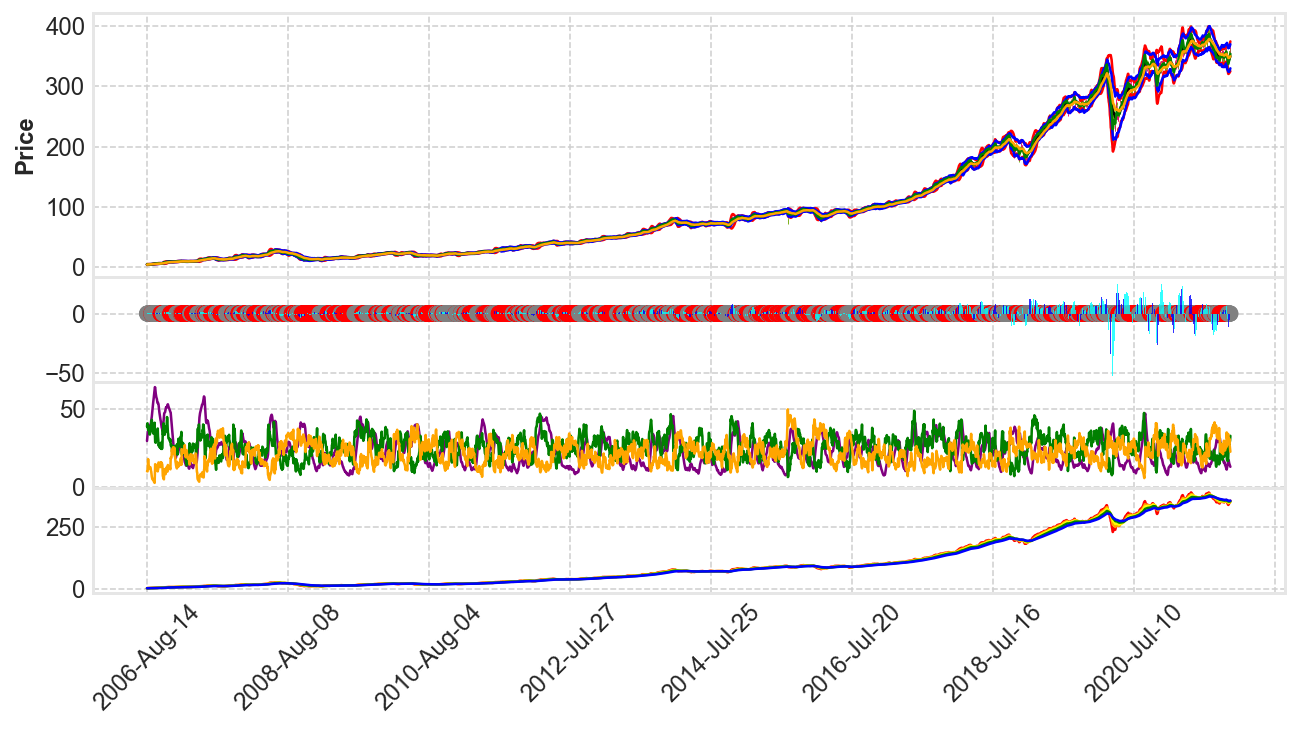
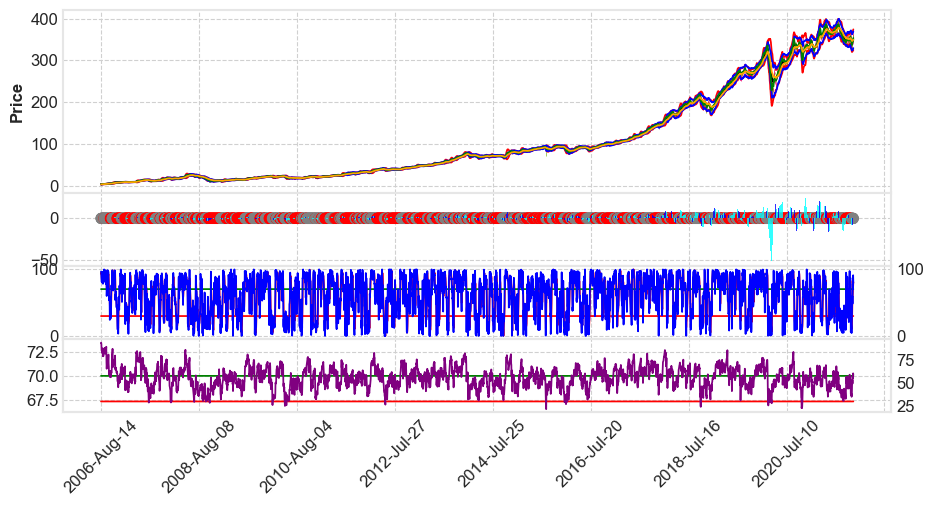
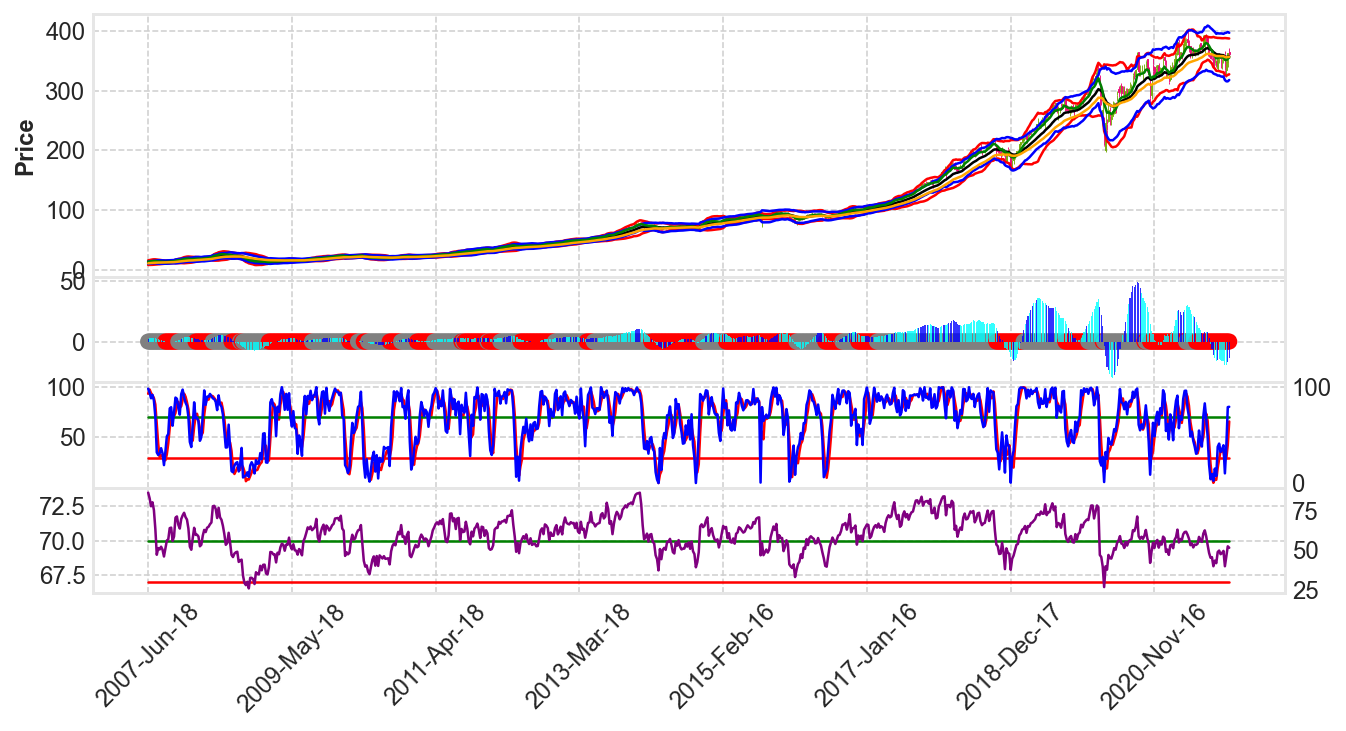
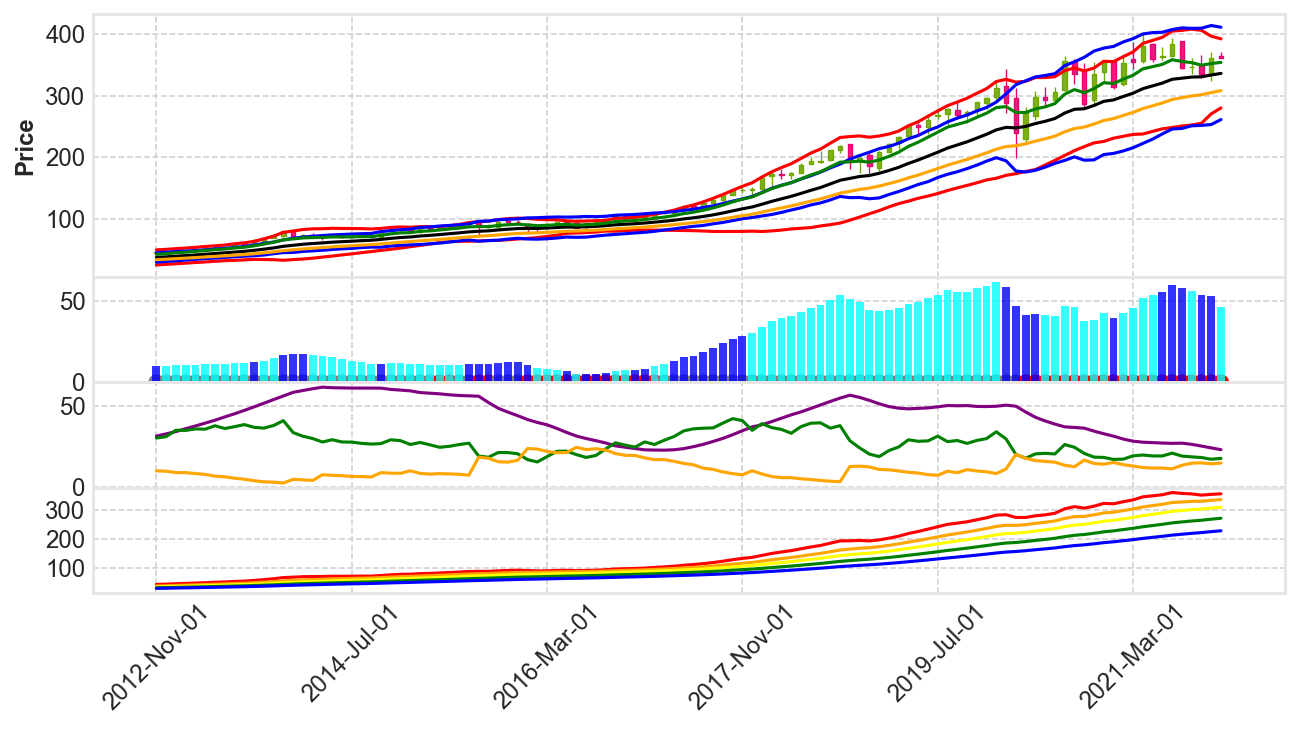
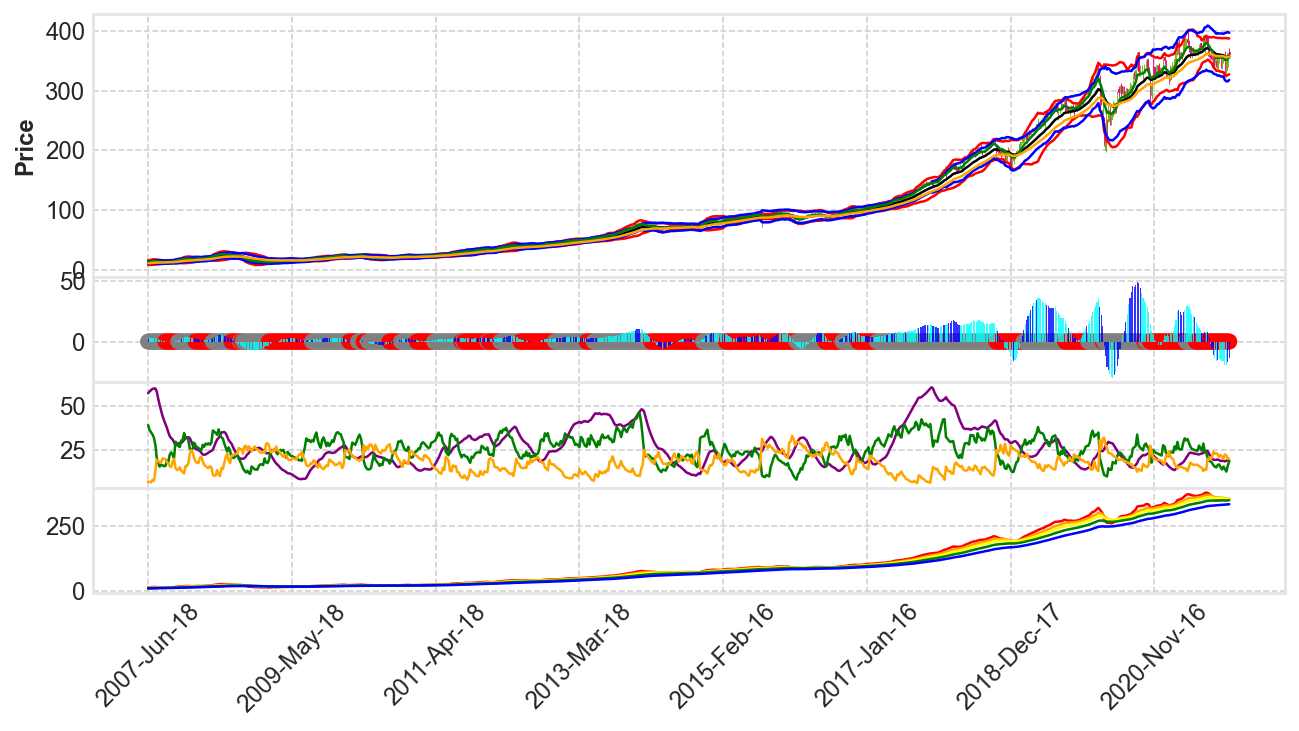
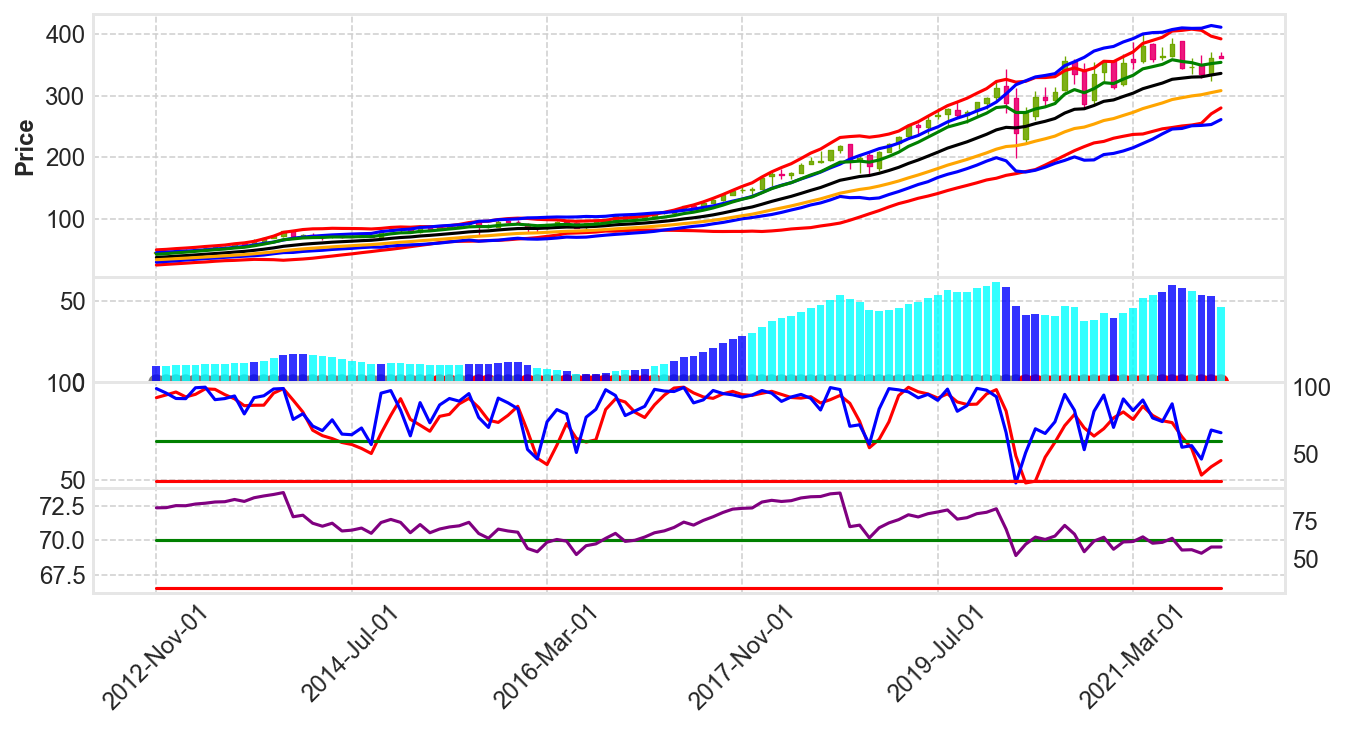

In [343]:
SF_dashboard.servable()